<!-- <img src="https://drive.google.com/uc?id=1oX9Tos0RxySyQuzz035udVCoL6UJWO8x" height="50" /> -->
<img src="https://drive.google.com/uc?id=1bNRbR2lTNYAcjdYB0TEMIOKrpHQhtm5u" height="50" />


**Here are the authors.** Do reach out to us for any queries or feedback!

* Viktor Mirjanic (vvm22@cam.ac.uk) \\
* Iulia Duta (id366@cam.ac.uk)


**Abstract:** This tutorial is designed to be a stand-alone introduction into the Graph Neural Network world. You will learn about the basics of working with graph data, implementing a standard Graph Network architecture and understand more about current challenges and open research problems in the field such as rewiring and positional encoding.


**Outline:**

The tutorial is structured as follow:
1.   Implement both a sparse and a dense version of **Graph Convolutional Network in Pytorch**.
2.   Write a training pipeline for graph inputs including **graph-level representation** and **custom mini-batching**.
3. Improve the Graph Convolutional Network using attention mechanisms - **Graph Attention Network**.
4. Make our first steps into **Pytorch Geometric**, a library dedicated to geometric deep learning.
5. Re-implement **Graph Attention Network in Pytorch Geometric**.
6. Understand the **over-squashing challenge** and experiment with **two graph rewiring techniques**: Graph Transformer and Expander Graph Propagation.
7. Explore various **positional encodings** for graph data.


 ❗ Note: While a GPU is not mandatory for this tutorial, we recommend using it to speed up the training. You can do this by clicking `Runtime -> Change runtime type`, and set the hardware accelerator to GPU.

## 😴 Preliminaries: Install, import and other modules

In [ ]:
# @title [RUN] Install required python libraries
!pip install -q networkx
!pip install -q mycolorpy
!pip install -q colorama
!pip install torch==2.1.0
!pip install -q torch-geometric

import os
import torch
os.environ['TORCH'] = torch.__version__
!pip install -q pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

!sudo apt-get install -qq graphviz graphviz-dev
!pip install -q pygraphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 61.1 MB/s eta 0:00:00
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 9.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2) ...
Selecting previously unselected package libgtk2.0-0:amd64.


In [ ]:
# @title [RUN] Import modules
import sys
import time
import math
import random
import itertools
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp
from scipy.stats import ortho_group
from scipy.linalg import block_diag

import pdb

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, Module, ModuleList, Sequential, Parameter, LayerNorm
from torch import Tensor
from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, softmax, get_laplacian, cumsum, add_self_loops
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.nn import MessagePassing, global_mean_pool, global_add_pool
# from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

from torch_geometric.nn.inits import glorot

from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from google.colab import files
from IPython.display import HTML

from numpy.linalg import eig, eigh

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title [RUN] Helper functions for plots and visualisations


def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None,
                   special_color=False, pos=None):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    if layout == 'custom':
      node_pos = pos
    elif layout == 'tree':
      node_pos=nx.nx_agraph.graphviz_layout(graph, prog='dot')
    else:
      node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color,
                            pos=graphs[i].pos)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def draw_one_tree(data):
    """draw a tree with networkx
    this function is only used to display the tree
    objects from the synthetic datasets
    """
    edges = data.edge_index.detach().cpu().numpy()
    feats = data.x.detach().cpu().numpy()

    graph = nx.DiGraph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    graph = graph.reverse()

    node_pos=nx.nx_agraph.graphviz_layout(graph, prog='dot')

    labels = dict()
    for i,node in enumerate(graph.nodes):
        labels[node] = f"{feats[node,0]}, {feats[node,1]}"


    colors = [0.5 for node in graph.nodes()]
    for i,node in enumerate(graph.nodes):
      if feats[node,0] != 0 and feats[node,1] == 0:
        colors[i] = 0.25
    #add colors according to node embeding
    nx.draw_networkx(graph, node_pos, node_size=500, labels=labels,
                     cmap=plt.get_cmap('Pastel1'), node_color=colors)



def plot_results(perf_per_epoch):
  df_results = pd.DataFrame(perf_per_epoch,
    columns=["Test AUC", "Val AUC", "Test loss",
             "Val loss", "Train loss", "Epoch", "Model"])
  p = sns.lineplot(x="Epoch", y="Val AUC", hue="Model", data=df_results)
  plt.show()
  p = sns.lineplot(x="Epoch", y="Test AUC", hue="Model", data=df_results)
  plt.show()

def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))


def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    total_num_nodes = 0
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
        total_num_nodes += graph.num_nodes
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)

    colored_matrix = "\n".join([" ".join(["{}"]*total_num_nodes)]*total_num_nodes).format(*[x for y in map_modified.tolist() for x in y])
    print(colored_matrix)

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


In [ ]:
# @title [RUN] Helper functions for generating synthetic data

# code based on: https://jhuow.fun/posts/barbell_graph/
def one_barbell_graph(n_clique, n_path):
  clique1 = nx.complete_graph(n_clique)
  clique1_pos = nx.circular_layout(clique1)
  clique2 = nx.complete_graph(n_clique)
  clique2_mapping = {node: node + n_clique for node in clique2}
  nx.relabel_nodes(clique2, clique2_mapping, copy=False) # avoids repeated nodes
  x_diff, y_diff = 8, -1
  clique2_pos = {node: clique1_pos[node-n_clique] + (x_diff, y_diff) for node in clique2}
  path = nx.path_graph(n_path)
  path_mapping = {node: node + 2 * n_clique for node in path}
  nx.relabel_nodes(path, path_mapping, copy=False) # avoids repeated nodes
  path_nodes = list(path.nodes)
  path_half1_nodes = path_nodes[:n_path//2]
  path_half2_nodes = path_nodes[n_path//2:]
  path_dist = 0.9
  clique2_entry = n_clique + n_clique // 2
  path_half1_pos = {node: clique1_pos[0] + (path_dist + i * path_dist, 0) for i, node in enumerate(path_half1_nodes)}
  path_half2_pos = {node: clique2_pos[clique2_entry] - (path_dist + i * path_dist, 0) for i, node in enumerate(path_half2_nodes[::-1])}
  path_pos = {**path_half1_pos, **path_half2_pos}
  barbell = nx.Graph()
  barbell.add_edges_from(clique1.edges)
  barbell.add_edges_from(clique2.edges)
  barbell.add_edges_from(path.edges)
  barbell.add_edges_from([(path_half1_nodes[0], 0), (path_half2_nodes[-1], clique2_entry)])
  clique_pos = {**clique1_pos, **clique2_pos}
  barbell_pos = {**clique_pos, **path_pos}
  barbell_dict = {}
  for k,v in barbell_pos.items():
    barbell_dict[k] = {"pos":v}
  nx.set_node_attributes(barbell, barbell_dict)
  return barbell

# code inspired by https://github.com/lrnzgiusti/on-oversquashing
def generate_barbell_graph(m1, m2, target_label):
    """
    Generate a barbell graph.

    Args:
    - m1:
    - m2:
    - target_label

    Returns:
    - Data: Torch geometric data structure containing graph details.
    """
    barbell_graph = one_barbell_graph(m1, m2)
    nodes = 2 * m1 + m2
    # Initialize node features. The first node gets 0s, while the last gets the target label
    x = np.ones((nodes, len(target_label)))
    x[0, :] = 0.0
    x[nodes - 1, :] = target_label
    x = torch.tensor(x, dtype=torch.float32)

    edge_index = torch.tensor(list(barbell_graph.edges())).T

    # Create a mask to indicate the target node (in this case, the first node)
    mask = torch.zeros(nodes, dtype=torch.bool)
    mask[0] = 1

    # Convert the one-hot encoded target label to its corresponding class index
    y = torch.tensor([np.argmax(target_label)], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, mask=mask, y=y, pos=nx.get_node_attributes(barbell_graph, 'pos'))


# The code for generating the tree dataset is based on:
# https://github.com/tech-srl/bottleneck
import math
class TreeDataset(object):
    def __init__(self, depth):
        super(TreeDataset, self).__init__()
        self.depth = depth
        self.num_nodes, self.edges, self.leaf_indices = self._create_blank_tree()
        # self.criterion = F.cross_entropy

    def add_child_edges(self, cur_node, max_node):
        edges = []
        leaf_indices = []
        stack = [(cur_node, max_node)]
        while len(stack) > 0:
            cur_node, max_node = stack.pop()
            if cur_node == max_node:
                leaf_indices.append(cur_node)
                continue
            left_child = cur_node + 1
            right_child = cur_node + 1 + ((max_node - cur_node) // 2)
            edges.append([left_child, cur_node])
            edges.append([right_child, cur_node])
            stack.append((right_child, max_node))
            stack.append((left_child, right_child - 1))
        return edges, leaf_indices

    def _create_blank_tree(self):
        max_node_id = 2 ** (self.depth + 1) - 2
        edges, leaf_indices = self.add_child_edges(cur_node=0, max_node=max_node_id)
        return max_node_id + 1, edges, leaf_indices

    def create_blank_tree(self, add_self_loops=True):
        edge_index = torch.tensor(self.edges).t()
        if add_self_loops:
            edge_index, _ = torch_geometric.utils.add_remaining_self_loops(edge_index=edge_index, )
        return edge_index

    def generate_data(self, transform=None, add_self_loops=True):
        data_list = []

        for comb in self.get_combinations():
            edge_index = self.create_blank_tree(add_self_loops=add_self_loops)
            nodes = torch.tensor(self.get_nodes_features(comb), dtype=torch.long)
            root_mask = torch.tensor([True] + [False] * (len(nodes) - 1))
            label = self.label(comb)
            graph = Data(x=nodes, edge_index=edge_index, root_mask=root_mask, y=label)
            if transform:
              graph = transform(graph)
            data_list.append(graph)

        dim0, out_dim = self.get_dims()
        return data_list, dim0, out_dim
        # X_train, X_test = train_test_split(
            # data_list, train_size=train_fraction, shuffle=True, stratify=[data.y for data in data_list])


        # return X_train, X_test, dim0, out_dim, self.criterion

    # Every sub-class should implement the following methods:
    def get_combinations(self):
        raise NotImplementedError

    def get_nodes_features(self, combination):
        raise NotImplementedError

    def label(self, combination):
        raise NotImplementedError

    def get_dims(self):
        raise NotImplementedError

class DictionaryLookupDataset(TreeDataset):
    def __init__(self, depth):
        super(DictionaryLookupDataset, self).__init__(depth)

    def get_combinations(self):
        # returns: an iterable of [key, permutation(leaves)]
        # number of combinations: (num_leaves!)*num_choices
        num_leaves = len(self.leaf_indices)
        num_permutations = 1000
        max_examples = 8000

        if self.depth > 3:
            per_depth_num_permutations = min(num_permutations, math.factorial(num_leaves), max_examples // num_leaves)
            permutations = [np.random.permutation(range(1, num_leaves + 1)) for _ in
                            range(per_depth_num_permutations)]
        else:
            permutations = random.sample(list(itertools.permutations(range(1, num_leaves + 1))),
                                         min(num_permutations, math.factorial(num_leaves)))

        return itertools.chain.from_iterable(

            zip(range(1, num_leaves + 1), itertools.repeat(perm))
            for perm in permutations)

    def get_nodes_features(self, combination):
        # combination: a list of indices
        # Each leaf contains a one-hot encoding of a key, and a one-hot encoding of the value
        # Every other node is empty, for now
        selected_key, values = combination

        # The root is [one-hot selected key] + [0 ... 0]
        nodes = [ (selected_key, 0) ]

        for i in range(1, self.num_nodes):
            if i in self.leaf_indices:
                leaf_num = self.leaf_indices.index(i)
                node = (leaf_num+1, values[leaf_num])
            else:
                node = (0, 0)
            nodes.append(node)
        return nodes

    def label(self, combination):
        selected_key, values = combination
        return int(values[selected_key - 1])

    def get_dims(self):
        # get input and output dims
        in_dim = len(self.leaf_indices)
        out_dim = len(self.leaf_indices)
        return in_dim, out_dim

In [ ]:
#@title [RUN] Set random seed for deterministic results
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

# <font color=green> 🔨 [Basic] **Towards Implementing our own Graph Neural Network** </font>


Graphs are very general data structures, which can represent a wide variety of natural phenomena. Mathematically, a graph is a tuple $G = (V, E)$ where
- $V$ is a set of vertices or **nodes** representing some entities
- $E$ is a set of **edges** between nodes representing pairwise relationship between entities.
 <!-- There is always at most one edge from node $u$ to $v$. -->

Graphs can be **directed** or **undirected**. A graph is undirected if edge from $u$ to $v$ exists if and only if a "backwards" edge from $v$ to $u$ also exists.

A **neighborhood** of a node $u$ is the set ${N}_u=\lbrace v\ | \left(u,v\right)\in E\rbrace$ of all nodes $v$ directly connected to $u$.

There exist different ways to store the edges of a graph:
- As an **adjacency matrix** $\mathbf{A}$, a $|V|\times|V|$ matrix such that $\mathbf{A}_{ij}=1$ if there is an edge between $i$th and $j$th node, and $0$ otherwise.
- As an **edge list** $\mathbf{E}$, a $2\times |E|$ matrix storing start and end indices of each edge.

Note that the order of vertices and edges is in principle arbitrary, but we have to decide on one to store the graph in memory.



🔎 Let's look at an example graph:

<image src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/2560px-6n-graf.svg.png" height="150px">

_(Image source: Wikipedia)_

It has 6 nodes and 7 edges. However, because it is _undirected_, we will be storing 14 entries!


Its edge list is:
$$\mathbf{E}=\begin{pmatrix}
1\ 2\ 1\ 5\ 2\ 5\ 2\ 3\ 3\ 4\ 4\ 5\ 4\ 6 \\
2\ 1\ 5\ 1\ 5\ 2\ 3\ 2\ 4\ 3\ 5\ 4\ 6\ 4
\end{pmatrix}$$

and its adjacency matrix is:

$$\mathbf{A}=\begin{pmatrix}
0\ {\color{red}{1}}\ 0\ 0\ {\color{red}{1}}\ 0 \\
{\color{red}{1}}\ 0\ {\color{red}{1}}\ 0\ {\color{red}{1}}\ 0 \\
0\ {\color{red}{1}}\ 0\ {\color{red}{1}}\ 0\ 0 \\
0\ 0\ {\color{red}{1}}\ 0\ {\color{red}{1}}\ {\color{red}{1}} \\
{\color{red}{1}}\ {\color{red}{1}}\ 0\ {\color{red}{1}}\ 0\ 0 \\
0\ 0\ 0\ {\color{red}{1}}\ 0\ 0
\end{pmatrix}$$

Note that as the graph is undirected, $\mathbf{A}$ is symmetrical along the main diagonal. Also, note that the main diagonal of $\mathbf{A}$ is zero because the graph does not have *self-loops* (i.e. edges connecting a node to itself $u\to u$).

The neighborhood of node $2$ is $N_2 =\{1,3,5\}$.

## Problem Setup

The diversity of tasks involving graph data led to the development of three major type of problems:

- **Node prediction**: we require on target for each node. *e.g. what is the topic of a paper given a citation network of papers?*
- **Link (edge) prediction**: we require on target for each pair of nodes. *e.g. are two people in a social network friends?*
- **Graph prediction**: we require a single target for the entire graph. *e.g. is this protein molecule (represented as a graph) likely going to be effective?*

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

_(Image source: Petar Veličković)_



In this part of the tutorial, we will work with the ZINC12K benchmark - a dataset containing about 12k molecules. Our goal is to predict, for each molecule, its "constrained solubility". This is a <ins> graph regression </ins> task as we need to predict a single value per graph.

Let's load the data. It might take a while 🫖 :


In [ ]:
from torch_geometric.datasets import ZINC

train_ds = ZINC(root='data/ZINC', split='train', subset=True)
val_ds = ZINC(root='data/ZINC', split='val', subset=True)
test_ds = ZINC(root='data/ZINC', split='test', subset=True)

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 6863.64it/s]
Done!


Now let's look at one molecule from the dataset:

In [ ]:
sample = train_ds[0]
gallery([sample], max_fig_size=(4, 6))

Graphs in ZINC have only one input feature - the atom's id, which is stored in `graph.x`. This molecule has 29 atoms (we can inspect this by looking at the `graph.num_nodes` attribute) and 64 edges (information stored in `graph.num_edges`).

The graph connectivity is represented as an edge list `graph.edge_index`, a $2\times |E|$ tensor containing starting nodes in the first row, and ending nodes in the second. This sparse representation has benefits that we will explore in a later section. For now, let's quickly convert this list into an adjacency matrix. We will store this dense representation in `graph.adj`.

❗️Note: the molecule also has _edge features_ stored in `graph.edge_attr`, which, for simplicity, we will ignore  in this part of the tutorial.

In [ ]:
from torch_geometric.utils import to_torch_coo_tensor

sample_adj = Data(x=sample.x, adj=to_torch_coo_tensor(sample.edge_index).to_dense())
print("The matrix containing the node features has shape: ", sample_adj.x.shape)
print("The adjacency matrix has shape: ", sample_adj.adj.shape)

## Graph Convolutional Network

As a first step in modeling our graph-shaped molecule, we will construct a [Graph Convolutional Network](https://arxiv.org/abs/1609.02907) (GCN) layer.

 The GCN is comparable to convolutional layers on image data, with one significant difference. Images are uniformly structured - its pixels are always ordered into a grid - and that allows convolutional layers to apply kernels on local patches. Following the assumption that pixels that are close in space should be correlated, a classical Convolutional Neural Network aggregates information from a local $D \times H$ patch.

Unlike pixels in images, nodes doesn't have a position in space. However, we can develop a similar intuition: nodes that are connected to each other in the graph should be more correlated than distant nodes. So, just like the kernels of Convolutional Neural Network are _local_ operations, we want our graph layers to respect the graph topology in a similar way. **Nodes that are close to each other according to the graph topology, should influence the representation more than the far away nodes.**
<!-- Thus, GNN layers need to take graph adjacency into account.  -->

<img src="https://drive.google.com/uc?id=1_4_7ivJqy6etS_CdO3fUPiZStVpN2_9L" height="200" />




For a graph $\mathbf{G}$ with $n$ nodes and $e$ edges, suppose we start with input node features $\mathbf{X}_{n\times d}$ and the adjacency matrix $\mathbf{A}_{n\times n}$. Let's consider the following operation:

$$
\mathbf{H} = \sigma \big( \mathbf{A} \mathbf{X} \mathbf{W} \big)
$$

where $\mathbf{W}_{d\times d'}$ are trainable weights, $\mathbf{H}_{n\times d'}$ are output node features, and $\sigma$ is a pointwise non-linearity.

<a name="node-level-gcn"></a>
On a per-node level, we can re-write this layer as

$$
\mathbf{h_i} = \sigma \big( \sum_{j \in \mathbf{N}_i} \mathbf{x_j}\mathbf{W}\big)
$$


where $\mathbf{N}_i$ denotes the neighbourhood of node $i$.

<font color = red> ✍ **Exercise:** Convince yourself that these two equations really mean the same thing!.





<!--
<img src="https://drive.google.com/uc?id=1UFS_7ZWEnMpLb_2dp05-22GIuBJVn_c_" height="300" /> -->

<img src="https://drive.google.com/uc?id=1ns-VqvfqANw3gtXpqWQwtdJmBQxXXsRk" height="300"/>


Observe how this simple layer **respects the graph topology** by only exchanging information between neighboring nodes via the adjacency matrix. This is perfectly in line with our requirements: a model in which **neighbours influence the representation more than the far away nodes**. Moreover, it nicely mirrors the Convolutional Network, where instead of the local image patches we are now aggregating neighbourhoods.

This layer has some problems, though. Graph nodes may have different degrees, possibly leading to numerical instabilities during training. To alleviate it, the [Graph Convolutional Network (GCN)](https://arxiv.org/abs/1609.02907) model introduces _symmetric normalization_:

$$
\mathbf{H}_\text{GCN} = \sigma \big( \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{X} \mathbf{W} \big)
$$

In this equation, $\mathbf{\tilde{A}}=\mathbf{A}+\mathbf{I}$ represent the adjacency matrix  enriched with self-loops (edges that connect a node with itself), and $\mathbf{\tilde{D}}$ is the degree matrix, a diagonal matrix containing degrees of $\mathbf{\tilde{A}}$,  $\mathbf{\tilde{D}}_{ii} = \sum_j \mathbf{\tilde{A}}_{ij}$ .

<font color = red> ✍ **Exercise:** Think about how can you write down the node-level action of this normalised GCN. What does adding $\mathbf{D}$ change in [this equation](#node-level-gcn)?



## <font color = orange> 🖋 **Task** Implement the symmetric normalization for the GCN layer using PyTorch.

> We expect you to implement $\mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}}$ as used in the GCN Layer
>
> 🆘 **Hint:** you may assume that the initial adjacency A does not have self-edges


In [ ]:
class GCNLayer(Module):

  def __init__(self, in_channels, out_channels):
    """
    One layer of Graph Convolutional Network (GCN)
    using the dense adjacency matrix

    Args:
        in_channels: (int) - input dimension
        out_channels: (int) - output dimension
    """
    super(GCNLayer, self).__init__()
    self.linear = Linear(in_channels, out_channels)

  def forward(self, x, A):
    """
    Args:
        x: (n, in_dim) - initial node features
        A: (n, n) - adjacency matrix

    Returns:
        out: (n, out_dim) - updated node features
    """
    # ============ ANSWER ==============
    # Compute the normalised adjacency matrix
    # as denoted by the equation above
    #
    Atilde = A + torch.eye(A.shape[0])
    Dtilde = torch.diag(1 / torch.sqrt(torch.sum(Atilde, dim=0)))
    adj_norm = Dtilde @ Atilde @ Dtilde
    #
    # ==============  OR  =====================
    #
    # Atilde = A + torch.eye(A.shape[0])
    # Dtilde = 1 / torch.sqrt(torch.sum(Atilde, dim=0))
    # adj_norm = torch.einsum('i,ij,j->ij', Dtilde, Atilde, Dtilde)
    #
    # ===========================================

    x = self.linear(x)
    out = adj_norm @ x
    return out

We will also create a simple model that uses our GCNLayer:

In [ ]:
class SimpleGCN(Module):
  def __init__(self):
    """
    A GNN model applying one GCN layers, to create graph-level representation

    """
    super().__init__()
    hidden = 64
    self.embed = Embedding(28, hidden)  # There are 28 different atoms in ZINC
    self.gcn = GCNLayer(hidden, 1)

  def forward(self, data):
    """
    Args:
        data: (PyG.Data) - one graph from the dataset

    Returns:
        out: (float) - a scalar representing the output for the entire graph
    """
    x = data.x
    A = data.adj

    x = self.embed(x).squeeze(1)
    x = F.relu(x)
    x = self.gcn(x, A)

    # ============ ANSWER ==============
    # (For Task 3)
    # return x
    # ==================================

    return torch.sum(x)


simple_gcn_model = SimpleGCN()

Let's apply our GCN network to our sample graph (the result should be a single number):

In [ ]:
simple_gcn_model(sample_adj).detach().numpy()

## Permutation Invarance and Equivariance

In the previous section we introduced the GCN layer in a hands-on way, by comparing it to convolutional layers used in image processing. Now, let's take a step back and think about the high level effect these layers have and why we would want them.

The two main concepts we will use to analyse the behavior of these layers are **invariance** and **equivariance**.

Suppose we want to detect whether a cat is in an image. The classifier should behave the same whether the cat is in the top-left, center, or right. Thus, it should be **invariant** to the **translation** of the image.
On the other hand, suppose we want to identify the _coordinates_ of a cat in the image. Then, the network should follow along with the image transformations - it should be **equivariant** to **translation**.
CNNs, by having weight sharing through use of kernels, enforce **translation equivariance** on the network. If needed for our task, we can then convert equivariance into invariance by pooling the entire image into a single output.




Now, lets turn to graphs.

On graphs we have no left, right, or up, so we cannot talk about translation symmetries of GNNs. But.. do you remember in the begining of this tutorial when we  had to <ins> randomly </ins> pick an order of the nodes in order to store them in memory? Since this is an arbitrary choice, we want our model to be invariant/equivariant to this decision.

We call this permutation invariance / permutation equivariance. A GNN is permutation invariant if, no mather how we permute the nodes the outoput doesn't change. On the other hand, a GNN is permutation equivariant if, by permuting the input, the output will permute in the same way. Generally, if our model outputs a graph-level representation we expect it to be permutation invariant. On the other hand, if the task prediction is at the node-level, the model should be permutation equivariant.

<!-- However, we can describe their _permutation_ symmetries, by whether or not they "respect" the adjacency matrix. - Iulia: I disagree with this sentence -->

Let's make this more formal.

<!-- We will say that a CNN network $\mathbf{F}$ is equivariant with respect to translation $\tau$ if it satisfies

$$
\mathbf{F}\left(\tau\left(\mathbf{X}\right)\right)=\tau\left(\mathbf{F}\left(\mathbf{X}\right)\right)
$$

Similarly, a network $f$ is translation invariant if this holds instead:

$$
f\left(\tau \left(\mathbf{X}\right)\right)=f\left(\mathbf{X}\right)
$$ -->

A GNN $\mathbf{f}$ is **permutation invariant** with respect to permutation matrix $\mathbf{P}$ if

$$
\mathbf{f}\left(\mathbf{X}, \mathbf{A}\right)=\mathbf{f}\left(\mathbf{P}\mathbf{X}, \mathbf{P}\mathbf{A}\mathbf{P}^\intercal\right)
$$

A GNN $\mathbf{f}$ is **permutation equivariant** with respect to permutation matrix $\mathbf{P}$ if

$$
\mathbf{P}\mathbf{f}\left(\mathbf{X}, \mathbf{A}\right)=\mathbf{f}\left(\mathbf{P}\mathbf{X}, \mathbf{P}\mathbf{A}\mathbf{P}^\intercal\right)
$$



Note how we have to transform the adjacency matrix as well as node features. Why?

As we mentione before, tasks on graphs typically don't depend on node ordering. That's why, when designing GNNs, **it is crucial to ensure that our layers fulfill these properties**.

<!-- The reason we focus on these properties is that they appear in the real world: image classification tasks are already translation invariant by design, and tasks on graphs typically don't depend on node ordering, which makes them permutation equivariant. Thus, by making these properties explicit, and **by encoding them directly into our architecture**, we obtain models that are aligned with our tasks. -->

## <font color = orange> 🖋 **Task** Write a unit test to check that the SimpleGCN is permutation invariant.

> Since on ZINC we predict one value per entire graph, the output should be permutation invariant. We will now test the permutation invariance of our simple model. All you need to do is to permute our sample graph. If everything is correct, SimpleGCN should output the same result for both the original and permuted molecule.






In [ ]:
def test_permutation(graph):
  # torch.random.manual_seed(42)
  # np.random.seed(42)

  perm = np.random.permutation(graph.x.shape[0])

  permuted_graph = Data(

  # ============ ANSWER ==============
  # Permute the features and the adjacency matrix according to perm
  #
      x = graph.x[perm],
      adj = graph.adj[perm][:, perm]
  #
  # ===========================================
      )


  assert torch.allclose(

  # ============ ANSWER ==============
  # (For Task 3)
  # Change next line to
  # simple_gcn_model(graph)[perm]
  # ==================================

    simple_gcn_model(graph),
    simple_gcn_model(permuted_graph)
    ), "Your model is not permutation invariant :("
  print("Success: Your GCN model is permutation invariant by construction!")

test_permutation(sample_adj)

## <font color = orange> 🖋 **Task** Modify the `SimpleGCN` to produce node-level as opposed to aggregated graph-level features.  Check that it <ins> breaks permutation invariance </ins> test and edit the test to check for permutation <ins> equivariance</ins> instead.


> Feel free to experiment with `SimpleGCN` and `GCNLayer` as we won't be using them beyond this point.
>
> 🆘 **Hint:** You need to edit only one line in both SimpleGCN and test_permutation for this task!


In [ ]:
# There is no extra code for this task - go back and edit SimpleGCN and test_permutation!

<font color = red> ✍ **Exercise:** Based on the formal definition, prove that GCN layer is permutation equivariant. (**Hint:** Which matrices commute?)

## From Dense to Sparse Adjacency Matrix </font>

The GCN layer we implemented above works correctly, but it is _inefficient_. Remember how we decided to use an adjacency matrix? This means that we created a $29\times 29$ matrix with only $64$ nonzero entries! Real-world graphs are often sparse, and we need to utilize their sparsity to save memory. (As we will see in the next section, with batching this effect becomes evein more pronounced.)

To accomplish this, we will now work directly with the provided `edge_index` matrix, without converting it into an adjacency matrix. Luckily, there are tools that will make this process easy!

Our main tool is the `scatter_sum` operator from [`torch_scatter`](https://pytorch-scatter.readthedocs.io/en/latest/index.html). A classical `torch.sum` takes two arguments and contracts a tensor by computing $\text{torch.sum}\left(\mathbf{A}, \text{dim}\right)=\sum_i \mathbf{A}\lbrack\dots, \underbrace{i}_{\text{dim}}, \dots\rbrack$. On the other hand, `scatter_sum` takes a third argument, `index`. The operation will first group the elements based on the indices represented in `index`, then sum-aggregate the elements in each group.

$$
\text{scatter_sum}\left(\mathbf{A},\text{index},\text{dim}\right)
\lbrack\dots, \underbrace{j}_{\text{dim}}, \dots\rbrack = \sum_i \mathbf{A}\lbrack\dots, \underbrace{i}_{\text{dim}}, \dots\rbrack \text{, where } \text{index}\lbrack i\rbrack = j
$$

Let's look at an example:

<img src="https://drive.google.com/uc?id=1gVBor-F077c7U3rdFv2ddrOxu_UiAmre" height="150"/>

<!-- <img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" width="300">

_(Image source: https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html)_ -->

The purpose of `scatter_sum` therefore is to aggregate groups of values in parallel, such as when summing over node neighborhoods in GCN!
Other `scatter_*` operations exist, including `scatter_mean` or `scatter_max`, which acts on a similar fashion, but perform a different operations on the selected groups.

The scatter sum has, loosely speaking, a one-sided inverse<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) called `torch.index_select`, which is also useful for creating GNN layers. Where `scatter_sum` _reduced_ tensor size by _aggregating_ entries based on index, `index_select` _increases_ size by _copying_ them. The operation it performs is:

$$
\text{index_select}\left(\mathbf{A},\text{index},\text{dim}\right)
\lbrack\dots, \underbrace{i}_{\text{dim}}, \dots\rbrack = \mathbf{A}\lbrack\dots, \underbrace{\text{index}\lbrack i \rbrack}_{\text{dim}}, \dots\rbrack
$$

where $i$ now ranges over $\text{index}$ and not over dimension $\text{dim}$ of
$\mathbf{A}$.

<img src="https://drive.google.com/uc?id=1AZ2ABSwVIY7sJo2KXofxXFR5Vb-cHK91" height="150"/>

<a name="cite_note-1"></a>1. [^](#cite_ref-1) This is not entirely true. What `scatter_*` operation is `torch.index_select` actually an inverse of, and under which conditions?

Lets see it in practice:

In [ ]:
# group and aggregate elements based on group index
array = torch.tensor([88, 15, 10, 7, 24, 30, 9])
index = torch.tensor([0,1,1,1,2,0,1])
agg_sum = scatter_sum(array, index=index, dim=0)
print(f"The results of scatter sum is {agg_sum}")

# select elements based on array index
array = torch.tensor([88, 15, 10, 7, 24, 30, 9])
index = torch.tensor([1, 1, 0, 2, 5, 4])
selected_array = torch.index_select(array, index=index, dim=0)
print(f"The selected elements are {selected_array}")


## <font color = orange> 🖋 **Task** Implement the same GCN as before, but using the sparse representation of the edges.

> This is not an easy task, but we will guide you step by step.
>
> The equation of a symmetrically-normalised GCN, represented at the node-level is:
>
> $$
\mathbf{h_i} =  \sum_{j \in \mathbf{N}_i} \frac{1}{\sqrt{d_id_j}}\mathbf{x_j}\mathbf{W}
$$
> where $d_i$ represents the degree of node $i$ and $N_i$ is the neighbourhood of node $i$ including self-loops.
>
> Our function will receive:
-  `x`: a $n \times f$ matrix
-  `edge_index`: a $2 \times e$ matrix.



> **Step 1:** Compute the degree vector $\mathbf{d}$ using the `edge_index` representation. To achieve this we will start with a vector full of ones $\mathbf{1}_e$ and group-sum them based on the list of source nodes stored in `edge_index[0]`. This way we will add 1 to $\mathbf{d}[i]$ whenever the node is identify as the source node of an edge



In [ ]:
# Step 1: compute the degree vector

# edge_index[0][k] represent the source node of edge k
# edge_index[1][k] represent the destination node of edge k
edge_index = torch.tensor([[0,1,1,2,2,3], [1,0,2,1,3,2]]) # 2xe tensor
d = torch.ones_like(edge_index[0]) # 2xe tensor

# ============ ANSWER ==============
d = scatter_sum(d, index=edge_index[0], dim=0)
# ===========================================

assert(torch.allclose(d, torch.tensor([1,2,2,1]), atol=1e-6))


 > **Step 2:** For each edge `(edge_index[0][k], edge_index[1][k])` compute the normalising coefficient $\frac{1}{\sqrt{\textbf{d}\text{[edge_index[0][k]]}\textbf{d}\text{[edge_index[1][k]]}}}$. To achieve that we form a vector $d_i$ of dimension $e$ in which $d_i[k]$ containing the degree of node `edge_index[0][k]`. Similarly vector $d_j[k]$ containing the degree of node `edge_index[1][k]`. We can easily achieve this by index-selecting from $\mathbf{d}$ based on `edge_index[0]` and `edge_index[1]` respectively. The final normalising coefficient should be obtain as an element-wise operation between the vectors $d_i$ and $d_j$: $c = 1/\sqrt{d_i d_j}$.


In [ ]:
# Step 2: compute the normalising coefficients

edge_index = torch.tensor([[0,1,1,2,2,3], [1,0,2,1,3,2]]) # 2xe tensor
# d[i] represent the degree of node i
d = torch.tensor([1,2,2,1]) # 1xn tensor

# ============ ANSWER ==============
# for each edge k extract from d the degree of the the source node edge_index[0][k]
# Hint: index_select might come handy
d_j = torch.index_select(d, index=edge_index[0], dim=0)

# for each edge k extract from d the degree of the the destination node edge_index[1][k]
d_i = torch.index_select(d, index=edge_index[1], dim=0)

# for each edge k compute 1/sqrt(di[k]dj[k])
c_ij = torch.unsqueeze(1 / torch.sqrt(d_i * d_j), -1)
# ===========================================


assert(torch.allclose(c_ij, torch.tensor([[0.7071],[0.7071],[0.5000],[0.5000],[0.7071],[0.7071]]), atol=1e-6))

> **Step 3:** For each edge `(edge_index[0][k], edge_index[1][k])` we compute the "message" between $j$=`edge_index[0][k]` and $i$=`edge_index[1][k]` as $\frac{1}{\sqrt{d_i d_j}}\mathbf{x_j}\mathbf{W}$. To do this we create the vector $x_j$ containing for each edge the representation of the source node (we can easily do that by index selecting from x using the list of source nodes `edge_index[0]`, linearly projecting it than rescale it using our precomputed normalising scalars `c` from Step 2.

<!-- >To avoid creating the full adjacency matrix, we will _lift_ our $n\times d$ node features to $|E|\times d$, normalize them, and then reduce them back to nodes.
>
>In the code below, for each edge $e_{ij}$, features corresponding to start node are stored in `x_j`, while those corresponding to end node are in `x_i`. (This way we are consistent with the [node-level representation of GCN](#node-level-gcn))
>
>How can you compute $\mathbf{D}$ from `edge_index` directly?
>
>🆘 Hint: you will need to use both `index_select` and `scatter_sum` multiple times in this task. -->

In [ ]:
# Step 3: compute the messages from i to j

edge_index = torch.tensor([[0,1,1,2,2,3], [1,0,2,1,3,2]]) # 2xe tensor
# c[k] represent the normalisation coefficient  1/sqrt(di[k]dj[k])
c = torch.tensor([[0.7071],[0.7071],[0.5000],[0.5000],[0.7071],[0.7071]]) # ex1 tensor
# x represent the input features
x = torch.ones(4,2)     # nxf tensor

linear_W = Linear(2, 3)

# ============ ANSWER ==============
# linearly project the node features
x = linear_W(x)

# for each edge k select as a message x_j
x_j = torch.index_select(x, index=edge_index[0], dim=0) #exf

# normalise the representation x_j using coefficients c_ij
m_ij = c_ij * x_j    # exf' tensor
# ===========================================

> **Step 4:** For each node, aggregate the received messages using sum aggregator.

In [ ]:
edge_index = torch.tensor([[0,1,1,2,2,3], [1,0,2,1,3,2]]) # 2xe tensor
# m_ij represent the messages between i and j
m_ij = torch.ones(6,3)  # exf' tensor

# ============ ANSWER ==============
# for each node aggregate the messages coming from its neighbour
# we ca have access the neighbourhood information in edge_index[1]
# Hint: scatter_sum might be useful
#
out = scatter_sum(m_ij, index=edge_index[1], dim=0) # nxf' tensor
# ===========================================

> Now we are ready to put everything together:

In [ ]:
class SparseGCNLayer(Module):
  def __init__(self, in_channels, out_channels):
    """
    One layer of Graph Convolutional Network (GCN)
    similar to the implemented before, but using the sparse
    representation of edges as opposed to the dense
    adjacency matrix.

    Args:
        in_channels: (int) - input dimension
        out_channels: (int) - output dimension
    """
    super().__init__()
    self.linear = Linear(in_channels, out_channels)

  def forward(self, x, edge_index):
    """
    Args:
        x: (n, in_dim) - initial node features
        edge_index: (2, e) - list of edge indices

    Returns:
        out: (n, out_dim) - updated node features
    """
    x = self.linear(x)

    edge_index = add_self_loops(edge_index)[0]  # Equivalent of Atilde = A + I
    x_j = torch.index_select(x, index=edge_index[0], dim=0)
    # x_i = torch.index_select(x, index=edge_index[1], dim=0) -- not used here

    # ============ ANSWER ==============
    #
    # Step 1: compute degree d
    d = scatter_sum(torch.ones_like(edge_index[0]), index=edge_index[0], dim=0)

    # Step 2: compute coefficients c_ij
    d_j = torch.index_select(d, index=edge_index[0], dim=0)
    d_i = torch.index_select(d, index=edge_index[1], dim=0)
    c_ij = torch.unsqueeze(1 / torch.sqrt(d_i * d_j), -1)

    # Step 3: Compute messages m_ij
    m_ij = c_ij * x_j

    # Step 4: Aggregate message into node representation
    out = scatter_sum(m_ij, index=edge_index[1], dim=0)
    #
    # ===========================================

    return out

Let's test the layer by passing our `sample` through it:

(note that we have to embed the node features first)

In [ ]:
out = SparseGCNLayer(64, 1)(Embedding(28, 64)(sample.x).squeeze(1), sample.edge_index)
print(out.shape)

The output should be a vector with $29$ entries - one for each node.

## Mini-batching for graph data

There is one final thing we need to add to create a training pipeline, and that is batching.  

When we think of batching we typically think of adding a whole new dimension to our input. However, this won't work here because graphs come in different shapes and sizes.

Instead, we perform mini-batching by **merging all graphs into <ins>one large batch graph </ins>**.

Lets's look at an example. Suppose we want to batch 3 graphs $\{G_1=(V_1, E_1)$, $G_2=(V_2, E_2)$, $G_3=(V_3, E_3)\}$. Our batch graph will be a large graph $G=(V_1 \cup V_2 \cup V_3, E_1 \cup E_2 \cup E_3)$. In order to be able to keeping track of which nodes came from which graph, we will use a list of indices stored in the `batch` attribute.

<font color = red> ✍ **Exercise:** Why does graph sparsity become an even bigger issue with batching?

<img src="https://drive.google.com/uc?id=1CKcdysFE19yxW4687TjBbJbpezUaEQ2P" height="350"/>

## <font color = orange> 🖋 **Task** Implement your own mini-batch by concatenating all graphs in a given list.

> ❗Be careful: when creating the new `edge_index`, you will need to increment node indeces to match new node positions in the large graph! You can use our already implemented `collate` function for this.
>
> You also need to create a `batch` array assigning a graph index to each node, so 0s for nodes in the first graph, 1s for nodes in the second graph and so on.

In [ ]:
def collate(values: List[Tensor], incs: List[int], dim: int) -> Tensor:
      """ Concatenate values along dim while incrementing based on incs"""
      incs = cumsum(torch.tensor(incs))
      return torch.cat([v + i for v, i in zip(values, incs)], dim=dim)


def create_mini_batch(graph_list: List[Data]) -> Data:
    """ Build a sparse graph from a batch of graphs """

    # ============ ANSWER ==============
    # To compute a batch graph you need to 1) concatenate the features
    # 2) concatenate and update the edge indexes and 3) create the batching
    # vector assigning each node to a graph
    #
    batch_x = torch.cat([graph.x for graph in graph_list], dim=0)
    batch_y = torch.cat([graph.y for graph in graph_list], dim=0)

    # We increment edge_indexes by graph size
    batch_edge_index = collate([graph.edge_index for graph in graph_list],
                               incs=[graph.x.size(0) for graph in graph_list],
                               dim=1)

    # We increment batch by 1
    batch_batch = collate([torch.zeros(graph.x.size(0)) for graph in graph_list],
                           incs=[1] * len(graph_list),
                           dim=0)
    #
    # ===========================================

    batch_batch = batch_batch.to(torch.int64)

    #create the big sparse graph
    batch_graph = Data(x=batch_x,
                       y=batch_y,
                       batch=batch_batch,
                       edge_index=batch_edge_index)
    return batch_graph

To test the batching implementation, we will visualise 2 graphs from the test dataset. If all is well, you should see two distinct molecules on top of each other:

In [ ]:
test_minibatch = create_mini_batch(test_ds[:2])
gallery([test_minibatch], max_fig_size=(8,6), node_emb=[test_minibatch.batch/2])

## <font color = orange> 🖋 **Task** Aggregate the node representations into graph-level representation for a batch of graphs.

> The GNN layers we implemented so far output a representation for each node. In order to obtain graph-level representations, we need to aggregate them according to the graph they are part of.
>
> Use the tools you learned about so far to complete the model below, which takes batched graphs and outputs a single prediction per graph. You need to implement the final step where node-level embeddings are converted to graph-level ones.
>
> 🆘 **Hint:** Compare this code to `SimpleGCN`. What needs to be done differently here? Where in the code do we need to use `batch`?

In [ ]:
class ZINCModel(Module):
  def __init__(self, model, hidden_dim, num_layers,
               **kwargs):
    """
    A GNN model applying a series of `model` layers
    to create graph-level representation

    Args:
        model: (Module) - the class of layers applied
                        inside the model
        hidden_dim: (int) - hidden dimension
        num_layers: (int) - number of layers
    """
    super().__init__()

    self.embed = Embedding(28, hidden_dim)
    self.layers = torch.nn.ModuleList(
        [model(in_channels=hidden_dim, out_channels=d, **kwargs)
        for d in (num_layers - 1) * [hidden_dim] + [1]])


  def forward(self, graph):
    """
    Args:
        graph: (PyG.Data) - a batch of graphs
    Returns:
        out: (float) - a scalar representing the output for the entire graph
    """
    x = graph.x
    batch = graph.batch
    edge_index = graph.edge_index

    x = self.embed(x).squeeze(1)
    for i in range(len(self.layers)):
      x = self.layers[i](x, edge_index=edge_index)
      if i < len(self.layers) - 1:
        x = F.relu(x)

    # ============ ANSWER ==============
    # Aggregate the node information into graph information
    # for each graph in the batch
    #
    x = scatter_sum(x, batch, dim=0)
    #
    # ===========================================

    out = x.squeeze(-1)
    return out

Let's test the model:

In [ ]:
ZINCModel(model=SparseGCNLayer, hidden_dim=32, num_layers=2)(create_mini_batch(train_ds[:2]))

We can finally train our model! We just need to load some boilerplate code for the training loop...

In [ ]:
# @title [RUN] Hyperparameters GCN
BATCH_SIZE = 64 #@param {type:"integer"}
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.005 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 4 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
def train(dataset, model, optimiser, epoch, loss_fct):
    """ Train model for one epoch
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()

        batch = batch.to(DEVICE)
        y_hat = model(batch)
        loss = loss_fct(y_hat, batch.y)

        loss.backward()
        optimiser.step()
    return loss.data

def evaluate(dataset, model, loss_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = math.ceil(len(dataset)/BATCH_SIZE)
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:min((i+1)*BATCH_SIZE, len(dataset))]  # Last batch is shorter
        batch = create_mini_batch(batch_list)
        batch = batch.to(DEVICE)

        y_hat = model(batch)
        loss = loss_fct(y_hat, batch.y)

        loss_eval += loss.data

    loss_eval /= num_iter
    return loss_eval

In [ ]:
def run_exp(model, train_dataset, val_dataset, test_dataset,
               loss_fct, lr, num_epochs):
    """ Train the model for NUM_EPOCHS epochs
    """
    print("\nModel architecture:")
    print(model)

    model = model.to(DEVICE)
    #Instantiatie our optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    training_stats = None

    #initial evaluation (before training)
    val_loss = evaluate(val_dataset, model, loss_fct)
    train_loss = evaluate(train_dataset[:BATCH_SIZE], model,
                                        loss_fct)
    epoch_stats = {'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    print("\nStart training:")
    for epoch in range(num_epochs):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss = train(train_dataset, model, optimiser, epoch,
                                        loss_fct)
        val_loss = evaluate(val_dataset, model, loss_fct)
        print(f"[Epoch {epoch+1}]",
                    f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(),
                      'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss = evaluate(test_dataset, model,  loss_fct)
    print(f"Done! Test loss: {test_loss:.3f}")
    return training_stats

... and let the magic happen:

In [ ]:
gcn_model = ZINCModel(model=SparseGCNLayer, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)

stats = run_exp(gcn_model, train_ds, val_ds,
                                  test_ds, loss_fct=F.mse_loss, lr=LR, num_epochs=NUM_EPOCHS)

In [ ]:
plot_stats(stats)

## Graph Attention Network

We will wrap up this section by implementing another popular GNN layer called [Graph Attention Network (GAT)](https://arxiv.org/abs/1710.10903).


Compared to Graph Convolutional Network, which statically aggregates the information from the node's neigbourhood, GAT Layers adopts a more powerful aggregation technique, by using an attention mechanism.


We define the GAT layer as


$$
\mathbf{h_i} = \sigma \big( \sum_{j \in N_i} \alpha\left(\mathbf{x_i}, \mathbf{x_j}\right) \mathbf{x_j} \mathbf{W}\big)
$$

where

$$
\alpha\left(\mathbf{x_i}, \mathbf{x_j}\right) = \sigma(\text{LeakyReLU}\left( \left(\mathbf{x_i}\mathbf{q}_1^T + \mathbf{x_j}\mathbf{q}_2^T\right)\right)) \in \mathbb{R}
$$

with $\mathbf{q}_1^T, \mathbf{q}_2^T \in \mathbb{R}^{d \times 1}$  and $\sigma$ is the softmax nonlinearity applied across each node's neighbourhood.

Concretly, in GCN, summation coefficients were *statically* determined by $\mathbf{A}$, while in GAT the aggregation is *dynamic*, with the weighted aggregation depending both on adjacency matrix $\mathbf{A}$ but also on  the features $\mathbf{X}$. The attention coefficient predicts the importance of each neighbour, permitting the model to block the information from some of the nodes if they are not relevant for the task.



<!-- Note: the original paper recommends concatenating $\mathbf{x_i}$ and $\mathbf{x_j}$, but virtually all implementations in the real world use addition instead, at no particular loss to the expressivity of the layer. -->


<!-- <img src="https://drive.google.com/uc?id=19K-_yrXjn7AM0NYvK556MdNf6r_MzyRn" height="300" /> -->

<img src="https://drive.google.com/uc?id=1nxEFw41NOWd27E40938zKqFaUjMTTdpz" height="300" />


## <font color = orange> 🖋 **Task** Implement the Graph Attention Layer using Pytorch.

> Implement the attention coefficients $\alpha$ for GAT in sparse form using `scatter_sum`.
>
> 🆘 **Hint:** we already imported `softmax` from `torch_geometric.utils`. It takes `index` as a second parameter, which determines groups that will be softmaxed independently of each other. Why is this useful here?

In [ ]:
class GATLayer(Module):
  def __init__(self, in_channels, out_channels):
    """
    One layer of Graph Attention Network (GAT)

    Args:
        in_channels: (int) - input dimension
        out_channels: (int) - output dimension
    """
    super().__init__()
    self.a_i = Linear(out_channels,1, bias=False)
    self.a_j = Linear(out_channels,1, bias=False)

    self.linear = Linear(in_channels, out_channels)
    self.negative_slope = 0.2

  def forward(self, x, edge_index):
    """
    Args:
        x: (n, in_dim) - initial node features
        edge_index: (2, e) - list of edge indices

    Returns:
        out: (n, out_dim) - updated node features
    """
    x = self.linear(x)
    # select all the source nodes for each edge
    x_j = torch.index_select(x, index=edge_index[0], dim=0)
    # select all the destination nodes for each edge
    x_i = torch.index_select(x, index=edge_index[1], dim=0)

    # ============ ANSWER ==============
    # Implement the equation above to compute the
    # node update corresonding to GAT
    #
    e = F.leaky_relu(self.a_i(x_i) + self.a_j(x_j), self.negative_slope)
    alpha = softmax(e, edge_index[0])
    out = scatter_sum(alpha * x_j, index=edge_index[1], dim=0)
    #
    # ===========================================

    return out

In [ ]:
# @title [RUN] Hyperparameters GAT
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.005 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 4 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
gat_model = ZINCModel(model=GATLayer, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)

stats = run_exp(gat_model, train_ds, val_ds, test_ds, loss_fct=F.mse_loss, lr=LR, num_epochs=NUM_EPOCHS)

In [ ]:
plot_stats(stats)

If all goes well, you should see GAT slightly outperform GCN.

🎉 Congratulations, you have finished the first half of the tutorial!

In the process, you reinvented many primitives that already exist in off-the-shelf GNN libraries. For example, lifting node representations to edges with `index_select` is already done more efficiently in `torch_geometric.nn.conv.MessagePassing.lift`, batching is implemented in `torch_geometric.loader.DataLoader`, and our `collate` is an oversimplified version of `torch_geometric.data.collate`. Feel free to check out these functions and compare.

In the upcoming half of this tutorial you will learn to work with this high-level API, but now you hopefully understand that there is nothing mysterious going on under the hood!

#  <font color=green> 🚼 [Intermediate] **First steps in Pytorch-Geometric** </font>


So far, we learned how to implement some GNN architectures using the standard [Pytorch library](https://pytorch.org/docs/stable/index.html). While this gives us a better understanding of what operations are happening inside a GNN, it can become quite cumbersome for more complex projects. Just think about how painful it was to implement your own graph batching (well done! 🥂) or how much memory you wasted storing a big adjacency matrix full of zeros.

To avoid these, for the rest of this practical we will use **Pytorch-Geometric library** (PyG). Pytorch Geometric is a library built on top of Pytorch, especially designed for a smoother handeling of geometric deep learning, providing easy-to-use mini-batching operation, several build-in GNN architectures, datasets and much more. If you never encounter PyG before don't worry, we will teach you step-by-step everything you need to know for this tutorial. However, if you want to explore more, there are some very useful tutorials on the [official platform](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html).


## Data object and mini-batching

In PyG, a graph is stored using the `Data` object, containg all the information about a graph $G(V,E)$:


>  **`data.x`**: a tensor of dimension $|V| \times C$ tensor containing the node features \
  **`data.edge_index`**: a tensor of dimension $2 \times |E|$ describing the graph connectivity \
  **`data.edge_attr`**: if applicable, a tensor of dimension $|E| \times K$ containing edge features \
  **`data.y`**: depending on the task, the target can contain labels either for each node, each edge or each graph

If needed, you can add your own attributes to the `data` object (we will see this later). Moreover, pyg provides a series of special attributes and functions that you can directly access such as `data.num_nodes`, `data.num_edges`, `data.has_isolated_nodes()` and [much more](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data).

🔍 Lets look at an example:

In [ ]:
x = torch.rand(3, 5)
edge_index = torch.tensor(
    [[0,1,2,0],[1,0,0,2]],
    dtype=torch.long
)
graph = Data(x=x, edge_index=edge_index)

print(f"Graph contains {graph.num_edges} edges, {graph.num_nodes} nodes, each characterised by {graph.x.shape[0]} features.")


Graph contains 4 edges, 3 nodes, each characterised by 3 features.


This is similar to the object returned by our ZINC datasets. However PyG allows us to batch and unbatch the graphs much quicker, using the `Batch` object. Lets try to do it:

In [ ]:
# Graph 1
x_1 = torch.tensor([[10.0], [0.5], [1.7]], dtype=torch.float)
edge_index_1 = torch.tensor(
    [[0, 1, 1, 2], [1, 0, 2, 1]],
    dtype=torch.long
)
data_1 = Data(x=x_1, edge_index=edge_index_1)

# Graph 2
x_2 = torch.tensor([[11.5], [120.2], [-100], [40.5]], dtype=torch.float)
edge_index_2 = torch.tensor(
    [[0, 2, 1, 0, 1], [2, 0, 0, 1, 3]],
    dtype=torch.long
)
data_2 = Data(x=x_2, edge_index=edge_index_2)

# Create a batch from the 2 graphs using Batch.from_data_list
data_list = [data_1, data_2]
batch = Batch.from_data_list(data_list)

dense_adjacency = to_dense_adj(batch.edge_index).numpy().squeeze()
print("Let's see if it does what we expect:")
print_color_numpy(dense_adjacency, data_list)
print(f"\nWe also have access to what graph each node it is part of via: {batch.batch}:")

# Unbatch the graphs via simple indexing
print(f"And we can still access the individual graphs in the batch: \n Graph 0: {batch[0]}, \n Graph 1: {batch[1]}")

Let's see if it does what we expect:
0 1 0 0 0 0 0
1 0 1 0 0 0 0
0 1 0 0 0 0 0
0 0 0 0 1 1 0
0 0 0 1 0 0 1
0 0 0 1 0 0 0
0 0 0 0 0 0 0

We also have access to what graph each node it is part of via: tensor([0, 0, 0, 1, 1, 1, 1]):
And we can still access the individual graphs in the batch: 
 Graph 0: Data(x=[3, 1], edge_index=[2, 4]), 
 Graph 1: Data(x=[4, 1], edge_index=[2, 5])


`Batch.from_data_list()` is useful when we have our own list of graphs to batch. On the other hand, the PyG `Dataloader` object handles all of the batching under the hood.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

# extract first batch from the ZINC dataset
first_batch = next(iter(train_loader))
print("This is the first batch in our dataset:", first_batch)

This is the first batch in our dataset: DataBatch(x=[123, 1], edge_index=[2, 272], edge_attr=[272], y=[4], batch=[123], ptr=[5])


## Message-Passing framework

Now that we are familiar to how graphs are stored in PyG, lets see how we create models using it. To understand how to implement a GNN model in PyG, we need to recap what the general **Message-Passing framework** is.

Lets consider a graph $G = (V,E)$, with $n$ nodes, $e$ edges, where each node $i$ is characterised by a feature vector $x_i \in \mathbb{R}^d$. If edge features are available, we denote them by $e_{ij} \in \mathbb{R}^f$. We represent by ${N}_i$ the set of neighbours for node $i$.

Most of the Graph Neural Network architectures are based on a $3$-step framework:

![](https://drive.google.com/uc?id=14cAQUiL8DEkM_HWDpi6InpF7f1geIS2O)


* <font color=blue> **Message step.** </font> For each pair of connected nodes $(i,j)$, the function $f_{msg}(x_i, x_j, e_{ij})$ will compute a message $m_{ij}$ representing the information sent between the $2$ nodes. Usually, this is implemented as an MLP which takes as input the concated input from the source node $x_j$, the destination node $x_i$ and the edge features $e_{ij}$. *Note that all these $3$ representations are optional and they can be omitted depending on the architecture.*

* <font color=orange> **Aggregate step.** </font> For each node $i$, the incoming messages received from all the neighbouring nodes $m_i = ⊕ (\{m_{ij, j \in N_i}\})$ are aggregated using a permutation-invariant operator $⨁$ such as sumation, average, maximum etc.

* <font color=purple> **Update step.** </font> For each node $i$, the aggregated information $m_i$ is combined with the previous representation $x_i$ using a function $f_{upd}(x_i, m_i)$ which can be implemented as an MLP over the concatenation of the input vectors.

🤔 Note that, most of the existing architectures including [GCN](https://arxiv.org/abs/1609.02907), [GAT](https://arxiv.org/abs/1710.10903) and [MPNN](https://arxiv.org/abs/1704.01212) are instantiations of this general framework. Take some time to think about what functions each of them are using.





We are now ready to implement such models in Pytorch Geometric. To create a message-passing based architecture, we inherit from the `MessagePassing` class, which[ take care of most of the propagation pipeline](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#the-messagepassing-base-class). All we need to do is to implement the three functions described above: `message`, `aggregate` and `update`.



```
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        ...

    def forward(self, x, edge_index, edge_attr):
        ...

    def message(self, x_i, x_j, edge_attr):
        ...

    def aggregate(self, inputs, index):
        ...

    def update(self, aggr_out, x):
        ...
```

>  \
**`forward(x, edge_index, edge_attr)`**: in the forward function, we simply need to call the `propagate()` function which automatically triggers the message passing procedure: `message()` -> `aggregate()` -> `update()`. \
\
  **`message(x_i, x_j, edge_attr)`**: this constructs messages from node j to node i for each pair of nodes (j,i) in the `edge_index`. The function will received all the arguments passed to the `propagate` function. Additionally, for all the node-related arguments $h$ received by propagate, the function will distinguish between the source node, represented as ` _j` and the destination node represented as `_i`. So, if we have two node-related arguments in the propagate call, $x$ and $h$, message function will receive 4 arguments `x_j`, `h_j` corresponding to the source node, and `x_i`, `h_i` corresponding to the destination. \
  \
  **`aggregate(inputs, index)`**: it receives the set of all messages computed above (`inputs`) together with a set of indices representing the destination node for all these messages. Functions like `scatter_mean`, `scatter_max` can be useful to implement various aggregators.\
\
  **`update(aggr_out, x)`**: receives the aggregated information from the above function (one for each node) together with any extra arguments received in the propagate, in order to compute the final node representation.\
  \



## Graph Attention Network in Pytorch-Geometric

As we mention before, most of the GNN architecture can be seen as a particular instantiation of the above $3$-steps framework.

The **Graph Attention Network** that you implemented in the begining of this tutorial is also an instance of the Message Passing framework.



![](https://drive.google.com/uc?id=1_GO3WRlFAviSv1MlzcMkyOt_jEYrv2gQ)

To implement the attention coefficient, various functions can be used. In [the original paper](https://arxiv.org/abs/1710.10903):

<!-- \begin{align}
 \alpha(x_i, x_j)=\sigma(f_1(x_i)+f_2(x_j))
\end{align}

  where $\sigma$ is LeakyReLu followed by softmax activation and $f_1$ and $f_2$ are 2 distinct MLPs $f_1, f_2: \mathbb{R}^d \rightarrow \mathbb{R}^1$. -->

$$
\alpha\left(\mathbf{x_i}, \mathbf{x_j}\right) = \sigma(\text{LeakyReLU}\left( \left(\mathbf{x_i}\mathbf{q}_1^T + \mathbf{x_j}\mathbf{q}_2^T\right)\right)) \in \mathbb{R}
$$

with $\mathbf{q}_1^T, \mathbf{q}_2^T \in \mathbb{R}^{d \times 1}$  and $\sigma$ is the softmax nonlinearity applied across each node's neighbourhood.



Lets use what we learned so far to implement the GAT layer in PyG.



## <font color = orange> 🖋 **Task** Implement a layer of Graph Attention Network using the Pytorch Geometric tools.

> Most of the code is provided for you. You just need to fill in the code corresponding to the message and update function:
>
> \begin{align}
f_{msg}(x_i, x_j)&=\alpha(x_i, x_j)x_j \\
f_{upd}(x, m)&=f(m)
\end{align}

In [ ]:
class GATpygLayer(MessagePassing):
    def __init__(self, in_dim, out_dim):
        """GAT Layer implemented using Pytorch Geometric

        Args:
            in_dim: (int) - input dimension for nodes `d`
            out_dim: (int) - output dimension `d_e`
        """
        super().__init__(node_dim=0, aggr='add')
        self.in_dim = in_dim
        self.out_dim = out_dim

        # ============ ANSWER =======================
        # Add new layers to compute the two linear projections
        # x_i - > x_i q_i^T and x_j -> x_j q_j^T
        #
        self.lin_q = Linear(in_dim, 1, bias=False)
        self.lin_k = Linear(in_dim, 1, bias=False)
        # ===========================================
        self.lin_upd = Linear(in_dim, out_dim, bias=False)


    def forward(self, x, edge_index):
        """
          The forward pass perform one round of message passing.

          By calling the `propagate()` function it automatically starts the
          `message()` -> `aggregate()` -> `update()` pipeline.

          Args:
              x: (n, in_dim) - initial node features
              edge_index: (2, e) - list of edges as a tuple

          Returns:
              out: (n, out_dim) - updated node features
        """
        out = self.propagate(edge_index, x=x)
        return out


    def message(self, x_i, x_j, edge_index_j):
        """ The `message()` function constructs the messages from nodes j
        to nodes i for each edge (j, i) in `edge_index`.

        This function receives all the arguments passed to the `propagate` function.
        For node-related features, it distinguish between the source and
        the destination node by appending `_i` or `_j` to the name.
        E.g. if `x` represents the node features, message will receive both `x_j`
        the features for source node and `x_i` the features of the destination.

        Args:
            x_j: (e, d) - source node features, essentially x[edge_index[0]]
            x_i: (e, d) - destination node features: x[edge_index[1]]
            edge_index_j: (e, d_e) - node index used to guide the softmax computation
        Returns:
            out: (e, d) - messages `m_ji`
        """

        # ============ ANSWER ==============
        # Compute alpha(x_i, x_j) as a tensor of dimension (e,)
        # storing the messages for each edge in edge_index
        #
        query_i = self.lin_q(x_i)
        key_j = self.lin_k(x_j)

        alpha = query_i + key_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_j)
        out = x_j * alpha.view(-1, 1)
        # ===========================================
        return out

    def update(self, aggr_out, x):
        """ update()` combines the aggregated messages with the initial nodes.

        `aggr_out` represent the result of the `aggregate()` step, whiel the
        rest of the arguments are all the arguments initially passed to
        `propagate()`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            x: (n, d) - initial node features

        Returns:
            out: (n, d') - updated node features
        """
        out = self.lin_upd(aggr_out)
        return out


In [ ]:
layer_gat = GATpygLayer(5,10)
x = torch.rand(3, 5)
edge_index = torch.tensor([[0,1,2,0],[1,0,0,2]], dtype=torch.long)
out = layer_gat(x, edge_index)
print(f"Layer output has shape: {out.shape}")

Layer output has shape: torch.Size([3, 10])


That's awesome!! You implemented your first model in PyG!! Lets use this layer to create a full GAT model for graph-level prediction.

You might have noticed that the code is vey similar to what you've implemented in the Pytorch section. However, thanks to the *magic* behind PyG , you don't need to `index_select` and `scatter_` all the time. 🪄  

In [ ]:
class GATpygModel(Module):
    def __init__(self, hidden_dim, num_layers=2):
        """GAT Neural Network model for graph-level regression

        Args:
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of GAT layers used in the model
        """
        super(GATpygModel, self).__init__()
        self.num_layers = num_layers

        # the ZINC node feature are integers representing the atom type
        # we convert them in vectorial representation using a learnable embedding
        self.embed_x = Embedding(28, hidden_dim)

        self.layers = [GATpygLayer(hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GATpygLayer(hidden_dim, 1)]
        self.layers = ModuleList(self.layers)

    def forward(self, graph):
        """
        Args:
            graph: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size,) - scalar prediction for each graph
        """
        x = self.embed_x(graph.x).squeeze(1)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.edge_index)
          x = F.relu(x)
        x = self.layers[-1](x, graph.edge_index)
        out = global_add_pool(x, graph.batch).squeeze(-1)

        return out

In [ ]:
#@title [RUN] Helper functions for train-eval models with PyG
# these are very similar to the ones used before, but now we are
# taking advantage of the PyG tools for loading and batching data

def train_pyg(loader, model, optimiser, epoch, loss_fct):
    """ Train model for one epoch
    """
    model.train()
    for batch in loader:
        batch = batch.to(DEVICE)
        optimiser.zero_grad()

        y_hat = model(batch)
        loss = loss_fct(y_hat, batch.y)

        loss.backward()
        optimiser.step()
    return loss.item()

def evaluate_pyg(loader, model, loss_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    loss_eval = 0
    for batch in loader:
        batch = batch.to(DEVICE)
        with torch.no_grad():
            y_hat = model(batch)
            loss = loss_fct(y_hat, batch.y)

            loss_eval += loss.item() * batch.num_graphs
    loss_eval /= len(loader.dataset)
    return loss_eval

def run_exp_pyg(model, train_loader, val_loader, test_loader, loss_fct,
                    lr=0.001, num_epochs=100):
    """ Train the model for NUM_EPOCHS epochs
    """
    print("\nModel architecture:")
    print(model)

    model = model.to(DEVICE)

    #Instantiatie our optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    training_stats = None

    #initial evaluation (before training)
    val_loss = evaluate_pyg(val_loader, model, loss_fct)
    train_loss = evaluate_pyg(train_loader, model, loss_fct)
    epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss, 'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    print("\nStart training:")
    for epoch in range(num_epochs):
        train_loss = train_pyg(train_loader, model, optimiser, epoch,
                                        loss_fct)
        val_loss = evaluate_pyg(val_loader, model, loss_fct)
        print(f"[Epoch {epoch+1}]",
                    f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss,
                      'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss = evaluate_pyg(test_loader, model,  loss_fct)
    print(f"Done! Test loss: {test_loss:.3f}")
    return training_stats

We are now ready to train our model on the molecular prediction problem.

In [ ]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
# @title [RUN] Hyperparameters GAT

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.005 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 4 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
model_gat_pyg = GATpygModel(HIDDEN_DIM, num_layers=NUM_LAYERS)
stats = run_exp_pyg(model_gat_pyg,  train_loader, val_loader, test_loader, loss_fct=F.mse_loss,
                    lr=LR, num_epochs=NUM_EPOCHS)


Model architecture:
GATpygModel(
  (embed_x): Embedding(28, 64)
  (layers): ModuleList(
    (0-3): 4 x GATpygLayer()
  )
)

Start training:
[Epoch 1] train loss: 0.734 val loss: 1.847
[Epoch 2] train loss: 0.701 val loss: 1.526
[Epoch 3] train loss: 0.777 val loss: 1.551
[Epoch 4] train loss: 0.867 val loss: 1.442
[Epoch 5] train loss: 1.931 val loss: 1.496
[Epoch 6] train loss: 1.375 val loss: 1.427
[Epoch 7] train loss: 0.459 val loss: 1.410
[Epoch 8] train loss: 1.577 val loss: 1.405
[Epoch 9] train loss: 0.861 val loss: 1.451
[Epoch 10] train loss: 1.178 val loss: 1.390
[Epoch 11] train loss: 0.501 val loss: 1.399
[Epoch 12] train loss: 1.571 val loss: 1.395
[Epoch 13] train loss: 0.280 val loss: 1.409
[Epoch 14] train loss: 0.258 val loss: 1.393
[Epoch 15] train loss: 0.674 val loss: 1.472
[Epoch 16] train loss: 0.718 val loss: 1.405
[Epoch 17] train loss: 0.298 val loss: 1.370
[Epoch 18] train loss: 0.471 val loss: 1.523
[Epoch 19] train loss: 0.632 val loss: 1.369
[Epoch 20] tr

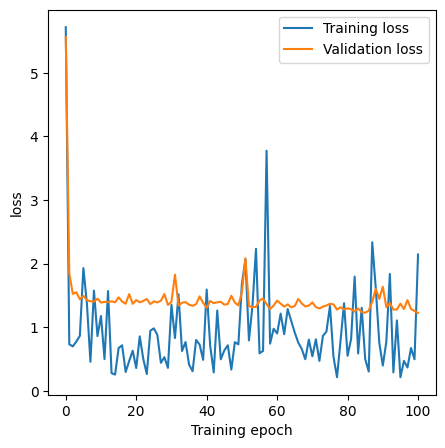

In [ ]:
plot_stats(stats)

❗ Note that, since this is the exact same architecture as the one you implemented in Pytorch, we don't expect an improvement in performance. This exercise was just such that you get experience playing with PyG.

## From Graph Attention Network to Graph Transformer

<!-- basically GAT with transformer-like attention and some extra twists (layer norm...) -->


As you've already seen several times during the summer school, one of the most popular neural network these days, across several domains, is the [Transformer](https://arxiv.org/abs/1706.03762) architecture. The key element of the Transformer layer is a particular type of attention known as <ins>key-query similarity<ins>.

To get a step closer to Transformers, we will modify the previous Graph Attention Layer, by replacing the original function used to infer the attention coefficient -- $\alpha(x_i, x_j)$ with the key-query similarity used in Transformers. This is the idea behind the first [**Graph Transformer** architecture](https://arxiv.org/abs/2312.11109) and the core observation that leads to popular idea that [*Transformers are Graph Neural Networks*](https://thegradient.pub/transformers-are-graph-neural-networks/).

Concretly, we will implement the following message function:

\begin{align}
f_{msg}(x_i, x_j)=\sigma(q(x_i)^Tk(x_j))v(x_j)
\end{align}

where $k,q: \mathbb{R}^d \rightarrow \mathbb{R}^f$ and $v: \mathbb{R}^d \rightarrow \mathbb{R}^o$ are 3 different linear layers and $\sigma$ is the softmax non-linearity.

❗️ *Note that, since we are already processing $v(x_j)$ in the message function, we can omit the update function entirely.*


## <font color = orange> 🖋 **Task** Implement the modified Graph Attention Layer, using dot-product attention.

> For our implementation:
>
> \begin{align}
f_{msg}(x_i, x_j)&=\sigma(q(x_i)^Tk(x_j))v(x_j)\\
f_{upd}(x,m)&=m \hspace{40mm} \small\text{  # this is the default update() behaviour}
\end{align}
>
> This is just one option to align the model with the message passing framework. Several equivalent alignments exist, and you are free to choose the one you prefer.
>
> ❗ Note that, in our code template, we postpone the application of the MLPs $f_*$ to be done in the message function. While applying them in the forward would be more efficient, we prefered this approach for educational purpose.

In [ ]:
class GTpygLayer(MessagePassing):
    def __init__(self, in_dim, out_dim, hid_dim):
        """Sparse Graph Transformer Layer implemented using Pytorch Geometric

        Args:
            in_dim: (int) - input dimension for node features
            out_dim: (int) - output dimension
            hid_dim: (int) - hidden dimension
            aggr: (int) - the type of aggregation used in the message passing
        """
        super().__init__(node_dim=0, aggr='add')
        self.in_dim = in_dim
        self.out_dim = out_dim

        # ============ ANSWER =======================
        # Add new layers to compute the three linear projections
        # x_i -> q(x_i); x_j -> k(x_i); x_j -> v(x_i)
        #
        self.lin_q = Linear(in_dim, hid_dim, bias=False)
        self.lin_k = Linear(in_dim, hid_dim, bias=False)
        self.lin_v = Linear(in_dim, out_dim, bias=False)
        # ===========================================


    def forward(self, x, edge_index):
        """
        Args:
            x: (n, in_dim) - initial node features
            edge_index: (2, e) - list of edges as a tuple

        Returns:
            out: (n, out_dim) - updated node features
        """
        out = self.propagate(edge_index, x=x)
        return out


    def message(self, x_i, x_j, edge_index_j):
        """
        Args:
            x_i: (e, in_dim) - features corresponding to destination nodes
            x_j: (e, in_dim) - features corresponding to source nodes
            edge_index_j: (e, d_e) - node index used to guide the softmax computation

        Returns:
            out: (n, out_dim) - updated node features
        """
        # ============ ANSWER =======================
        # Compute alpha(x_i, x_j) as a tensor of dimension (e,)
        # storing the messages for each edge in edge_index
        #
        query_i = self.lin_q(x_i)
        key_j = self.lin_k(x_j)
        value_j = self.lin_v(x_j)

        alpha = (query_i * key_j).sum(dim=-1)
        alpha = softmax(alpha, edge_index_j)

        out = value_j * alpha.view(-1, 1)
        # ===========================================
        return out

In [ ]:
model = GTpygLayer(5,10, 16)
x = torch.rand(3, 5)
edge_index = torch.tensor([[0,1,2,0],[1,0,0,2]], dtype=torch.long)
out = model(x, edge_index)
print(out.shape)

torch.Size([3, 10])


In [ ]:
class GTpygModel(Module):
    def __init__(self, hidden_dim, num_layers=2):
        """
        Sparse Graph Transformer Neural Network model for graph-level regression

        Args:
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of GT layers used in the model
        """
        super(GTpygModel, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2

        # the ZINC node feature are integers representing the atom type
        # we convert them in vectorial representation using a learnable embedding
        self.embed_x = Embedding(28,hidden_dim)

        self.layers = [GTpygLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GTpygLayer(hidden_dim, 1, hidden_dim)]
        self.layers = ModuleList(self.layers)

    def forward(self, graph):
        """
        Args:
            graph: (PyG.Data) - batch of PyG graphs
        Returns:
           out: (batch_size,) - scalar prediction for each graph in the batch
        """
        x = self.embed_x(graph.x).squeeze(1)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.edge_index)
          x = F.relu(x)
        x = self.layers[-1](x, graph.edge_index)
        out = global_add_pool(x, graph.batch)

        out = out.squeeze(-1)
        return out

Lets train and evaluate this new model on the molecular prediction task we used before.

In [ ]:
# @title [RUN] Hyperparameters GT

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 4 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
model_gt_pyg = GTpygModel(HIDDEN_DIM, num_layers=NUM_LAYERS)
stats = run_exp_pyg(model_gt_pyg,  train_loader, val_loader, test_loader, loss_fct=F.mse_loss,
                    lr=LR, num_epochs=NUM_EPOCHS)


Model architecture:
GTpygModel(
  (embed_x): Embedding(28, 64)
  (layers): ModuleList(
    (0-3): 4 x GTpygLayer()
  )
)

Start training:
[Epoch 1] train loss: 3.191 val loss: 1.512
[Epoch 2] train loss: 0.793 val loss: 1.491
[Epoch 3] train loss: 7.929 val loss: 1.469
[Epoch 4] train loss: 0.735 val loss: 1.463
[Epoch 5] train loss: 0.913 val loss: 1.439
[Epoch 6] train loss: 2.827 val loss: 1.437
[Epoch 7] train loss: 0.557 val loss: 1.450
[Epoch 8] train loss: 1.052 val loss: 1.562
[Epoch 9] train loss: 0.472 val loss: 1.442
[Epoch 10] train loss: 0.942 val loss: 1.688
[Epoch 11] train loss: 1.010 val loss: 1.609
[Epoch 12] train loss: 0.527 val loss: 1.420
[Epoch 13] train loss: 9.033 val loss: 1.443
[Epoch 14] train loss: 0.459 val loss: 1.477
[Epoch 15] train loss: 0.920 val loss: 1.419
[Epoch 16] train loss: 1.111 val loss: 1.415
[Epoch 17] train loss: 0.770 val loss: 1.549
[Epoch 18] train loss: 1.115 val loss: 1.410
[Epoch 19] train loss: 1.507 val loss: 1.443
[Epoch 20] trai

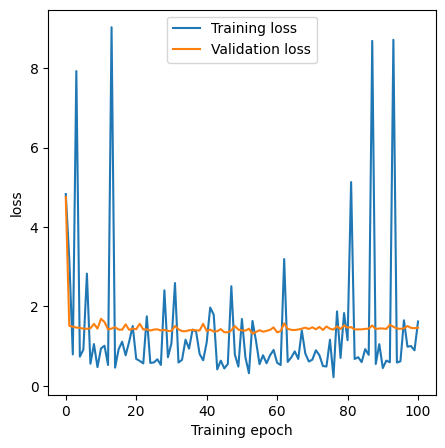

In [ ]:
plot_stats(stats)

If everythings go well, the results should be on par with the previous GAT model. Multiple heads cand be added to improve the performance, but this is beyond the goal of this tutorial.

# <font color=green> ⏳ [Advanced] **Over-squashing: a bottleneck problem in Graph Networks** </font>

Graph Neural Networks are powerful models that, [under certain conditions](https://arxiv.org/abs/1810.00826), can distinguish a large class of non-isomorphic graphs. However, there are still scenarios where standard graph neural networks fall short.

To get an intuition about challenges in Graph Neural Networks, lets look at the following ❚█══█❚ graph.

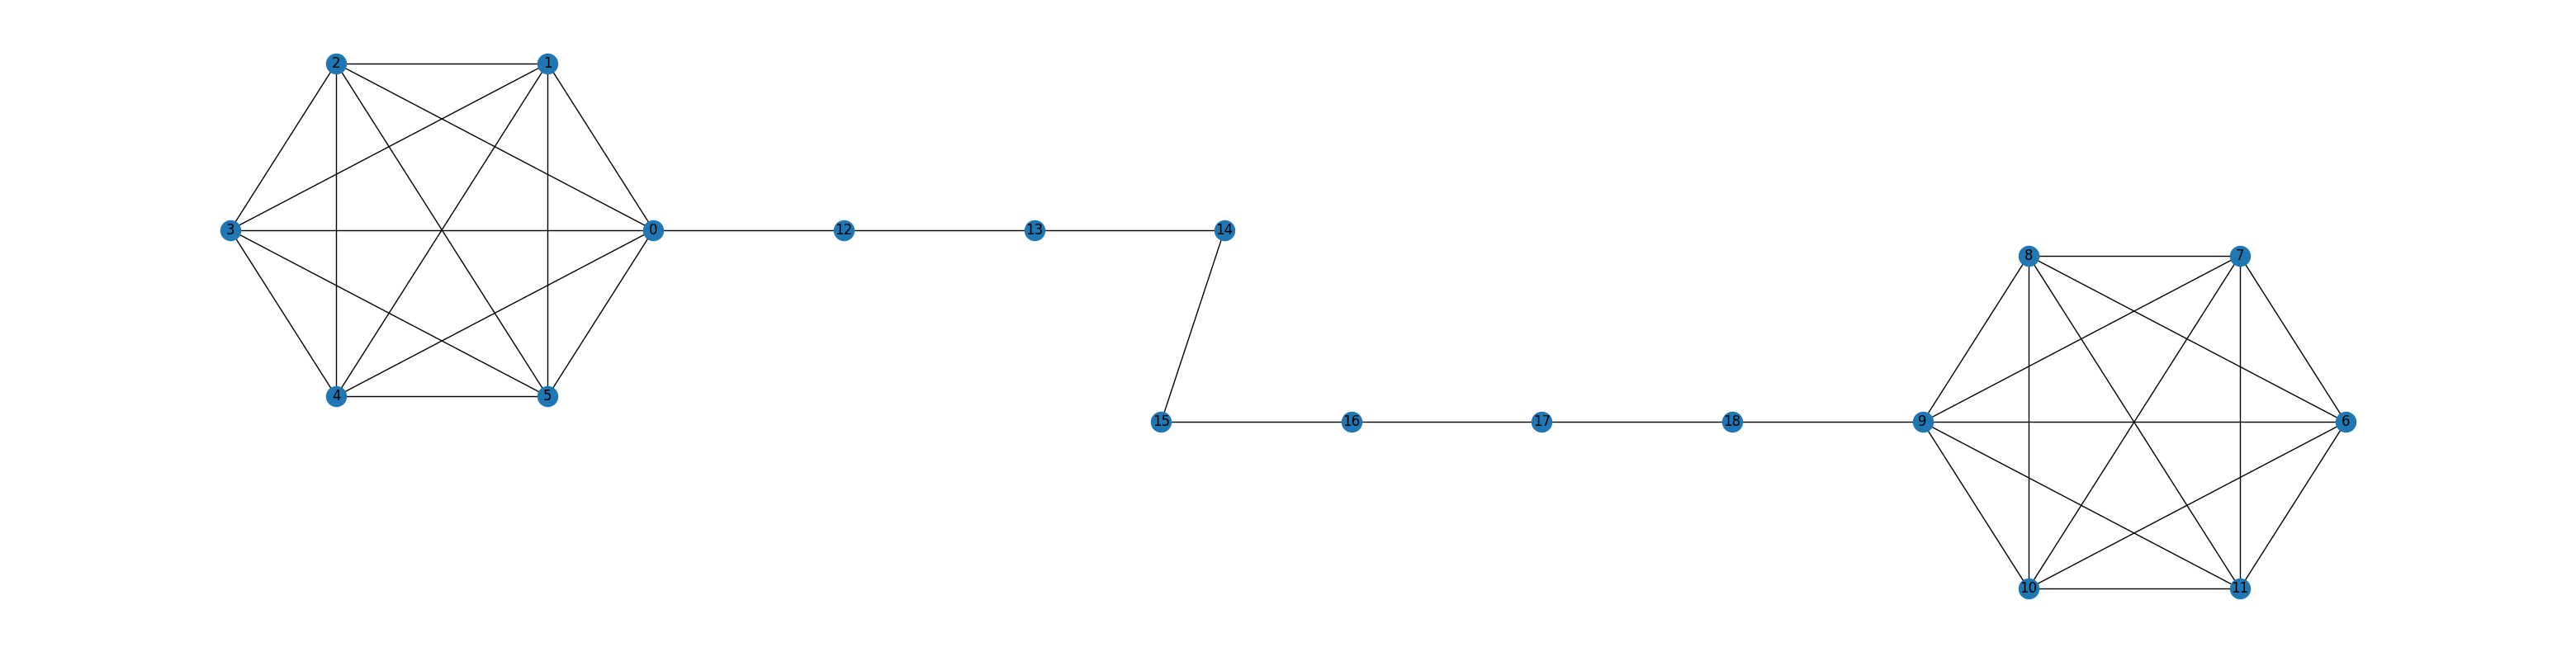

In [ ]:
graph = generate_barbell_graph(m1=6, m2=7, target_label=[0,0,1])
gallery([graph], layout='custom')

If our task requires sending messages between one node from the left clique (lets call it A) and another node from the right clique (lets call it B), this message needs to travers the thin *bridge* connecting A and B. However, besides the information we are interested in, there is a high number of messages (all the possible messages from a node in A to a node in B, a total of $|A| \times |B|$) traversing that bridge. This means that, the pairwise messages exchanged by the nodes forming the bridge $\{0, 9, 12, 13 \dots 18\}$ need to be capable of preserving all the information from this increasing number of messages.

This problem is called **[over-squashing](https://arxiv.org/pdf/2006.05205)**. In simpler words, the information from an exponentially-growing set of messages is compressed into fixed-length node vectors.


<figure>
<img src="https://drive.google.com/uc?id=1GTKuG13g5Cy7wi_srBaIGX3ky31MEkgV"  width="300" height="150">
<figcaption>Image from  <a href="https://arxiv.org/pdf/2006.05205"> the paper </a></figcaption>
</figure>


## Long-range Node Transfer in a Tree 🌴

To understand the over-squashing problem better, we are gonna use a [synthetic dataset ](https://arxiv.org/pdf/2006.05205) especially designed for that. Lets consider a tree (a connected graph without cycles) of depth $r$. All the nodes have $(0,0)$ features except from the leaves wich are labeled (id, value) and the root node which is labeled (id, $0$). For the (id, value) pairs, each value is uniquely associated to an id. The goal is, from the features of the root node, to predict the value corresponding to the node's id. In order to solve this task, all the leaves needs to send their (id, value) message to the root node, and the root needs to select the one with the same id as itself in order to find its corresponding value.  

Lets look at an example:

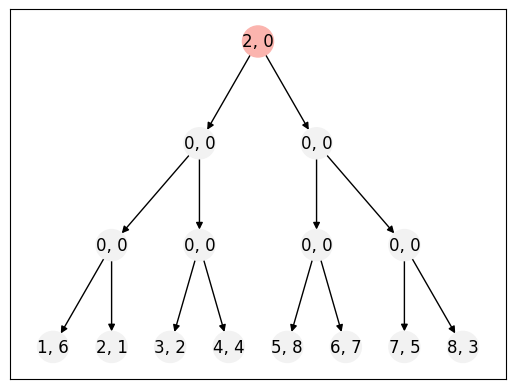

In [ ]:
tree_dataset, dim0, num_classes = DictionaryLookupDataset(3).generate_data(add_self_loops=False)
draw_one_tree(tree_dataset[1])

In the example above, the root node has id $2$. Among the leaf nodes, the id $2$ corresponds to the value 1. Thus, the root node should predict 1.

As the tree becomes deeper, both the distance and the number of messages from the leafs to the root increases. This is a particularly challenging problem  for a message passing GNN, since it will require the summarisation of an *increasingly number of messages* on a finite vectorial representation.


To understand to what extent over-squashing is a problem in practice, we will train and evaluate our current models on this synthetic dataset.

In [ ]:
tree_dataset, dim0, num_classes = DictionaryLookupDataset(4).generate_data()

train_syn_data = tree_dataset[:1000]
val_syn_data = tree_dataset[1000:2000]
test_syn_data = tree_dataset[2000:3000]

batch_size = 128
train_syn_loader = DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)
val_syn_loader = DataLoader(tree_dataset, batch_size=batch_size, shuffle=False)
test_syn_loader = DataLoader(tree_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"Number of classes: {num_classes}")
graph = tree_dataset[0]
print(f"Node features for graph 0:\n {tree_dataset[0].x.T}")
print(f"Target label for graph 0: {tree_dataset[0].y}") # first graph has class 0
print(f"Source node for graph 0: {tree_dataset[0].root_mask.int()}") # the node denoted by 1 is the source node

Number of classes: 16
Node features for graph 0:
 tensor([[ 1,  0,  0,  0,  1,  2,  0,  3,  4,  0,  0,  5,  6,  0,  7,  8,  0,  0,
          0,  9, 10,  0, 11, 12,  0,  0, 13, 14,  0, 15, 16],
        [ 0,  0,  0,  0,  5, 13,  0,  8, 10,  0,  0, 14,  7,  0, 11, 16,  0,  0,
          0, 12,  2,  0,  9,  4,  0,  0,  3,  1,  0, 15,  6]])
Target label for graph 0: 5
Source node for graph 0: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


## <font color = orange> 🖋 **Task** Modify the below graph model class to output the prediction *only* from the source node information (as denoted by the `data.root_mask` attribute) instead of computing the average global pooling as before.


> ❗ Note that since we are interested in analysing the capacity of the GNN architectures to model this task, our primary metrics will be the train loss / train accuracy. A model uncapable of sending long-distance message not only will struggle to generalized on validation set, but will also perform poorly on the training set.

In [ ]:
class GTpygSynModel(Module):
    def __init__(self, output_dim, hidden_dim, num_layers=2, dim_emb=0):
        """
        Sparse Graph Transformer Neural Network model for root-node-level classification

        In our synthetic task the prediction needs to be done only
        from the features of the root node stored in root_mask attribute

        Args:
            output_dim: (int) - output dimension (number of classes)
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of GT layers used in the model
            dim_emb: (int) - number of potential ids/vals in the TREE
                            (characterstic to the dataset)
        """
        super(GTpygSynModel, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2

        self.layer0_keys = Embedding(num_embeddings=dim_emb + 1, embedding_dim=hidden_dim)
        self.layer0_values = Embedding(num_embeddings=dim_emb + 1, embedding_dim=hidden_dim)

        self.layers = [GTpygLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GTpygLayer(hidden_dim, output_dim, hidden_dim)]
        self.layer_norms = [torch_geometric.nn.LayerNorm(hidden_dim) for _ in range(num_layers-1)]

        self.layers = ModuleList(self.layers)
        self.layer_norms = ModuleList(self.layer_norms)

    def forward(self, graph):
        """
        Args:
            graph (PyG.Data): batch of PyG graphs
        Returns:
            out (batch_size, output_dim): updated representation for the root nodes
        """
        # we changed the atom embedding with an id-embedding and a value-embedding
        # the final node input features will be the sum of the id and value embedding
        x_key, x_val = graph.x[:, 0], graph.x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        new_x = x_key_embed + x_val_embed

        x = new_x

        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.edge_index)
          x = F.relu(x)
          x = x + new_x
          x = self.layer_norms[i](x)
          new_x = x
        x = self.layers[-1](x, graph.edge_index)

        # ============ ANSWER =======================
        # From x extract only the information corresponging to
        # the root node as indicated by graph.root_mask
        #
        out = x[graph.root_mask]
        # ===========================================

        return out

In [ ]:
#@title [RUN] Helper functions for train-eval models.

def train_syn(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0
    pred_all = []
    gt_all = []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        y_pred = model(data)
        pred_all.extend(y_pred.detach().cpu())
        gt_all.extend(data.y)

        loss = F.cross_entropy(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()

    pred_all = torch.stack(pred_all).cpu().numpy()
    gt_all = torch.stack(gt_all).cpu().numpy()
    return loss_all / len(train_loader.dataset), pred_all, gt_all


def eval_syn(model, loader, device):
    model.eval()
    loss = 0

    pred_all = []
    gt_all = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            pred_all.extend(y_pred.detach().cpu())
            gt_all.extend(data.y.detach().cpu())

            loss = F.cross_entropy(y_pred, data.y)
            loss += loss.item() * data.num_graphs

    pred_all = torch.stack(pred_all).cpu().numpy()
    gt_all = torch.stack(gt_all).cpu().numpy()
    return loss / len(loader.dataset), pred_all, gt_all


def run_exp_syn(model, train_loader, val_loader, test_loader,
                    lr=0.001, n_epochs=100):

    print("\nModel architecture:")
    print(model)
    device = DEVICE
    model = model.to(device)

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_acc = None
    training_stats =  None # Track Test/Val MAE vs. epoch (for plotting)

    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        train_loss, train_pred, train_gt = train_syn(model, train_loader, optimizer, device)
        # print(np.argmax(train_pred, -1), train_gt)
        train_acc = accuracy_score(train_gt, np.argmax(train_pred, -1))

        # Evaluate model on validation set
        val_loss, val_pred, val_gt = eval_syn(model, val_loader, device)
        val_acc = accuracy_score(val_gt, np.argmax(val_pred, -1))

        if best_val_acc is None or val_acc >= best_val_acc:
            # Evaluate model on test set if validation metric improves
            test_loss, test_pred, test_gt = eval_syn(model, test_loader, device)
            test_acc = accuracy_score(test_gt, np.argmax(test_pred, -1))
            best_val_loss = val_loss
            best_val_acc = val_acc


        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Train Loss: {train_loss:.7f},\n '
                  f'Val Loss: {val_loss:.7f}, Test Loss: {test_loss:.7f}\n',
                  f'Train Acc: {train_acc:.7f}\n')
                  # f'Val Acc: {val_acc:.7f}, Test Acc: {test_acc:.7f}\n')

        epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss, 'train_acc':train_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)

    print("Done")

    return training_stats

In [ ]:
# @title [RUN] Hyperparameters GT

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 32 #@param {type:"integer"}
NUM_LAYERS = 5 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
model_gt_syn = GTpygSynModel(num_classes+1, HIDDEN_DIM, num_layers=NUM_LAYERS, dim_emb=dim0)
gt_perf_per_epoch = run_exp_syn(model_gt_syn, train_syn_loader, val_syn_loader, test_syn_loader,
                    lr=LR, n_epochs=NUM_EPOCHS)


Model architecture:
GTpygSynModel(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (layers): ModuleList(
    (0-4): 5 x GTpygLayer()
  )
  (layer_norms): ModuleList(
    (0-3): 4 x LayerNorm(32, affine=True, mode=graph)
  )
)

Start training:
Epoch: 010, LR: 0.001000, Train Loss: 2.7713470,
 Val Loss: 0.0225642, Test Loss: 0.0225642
 Train Acc: 0.0776250

Epoch: 020, LR: 0.001000, Train Loss: 2.7633346,
 Val Loss: 0.0224359, Test Loss: 0.0223975
 Train Acc: 0.0795000

Epoch: 030, LR: 0.001000, Train Loss: 2.7612526,
 Val Loss: 0.0224787, Test Loss: 0.0223697
 Train Acc: 0.0833750

Epoch: 040, LR: 0.001000, Train Loss: 2.7322195,
 Val Loss: 0.0222182, Test Loss: 0.0223464
 Train Acc: 0.0850000

Epoch: 050, LR: 0.001000, Train Loss: 2.7255948,
 Val Loss: 0.0221088, Test Loss: 0.0221127
 Train Acc: 0.0876250

Epoch: 060, LR: 0.001000, Train Loss: 2.7611466,
 Val Loss: 0.0223044, Test Loss: 0.0221127
 Train Acc: 0.0822500

Epoch: 070, LR: 0.001000, Train Loss: 2.

The performance of our model seems to be far from satisfactory, due to the over-squashing phenomena we discussed above.

Some of the real-world problems might not require long-distance messages, thus a normal Message Passing GNN would be enough to solve it. However, if sending messages between distance nodes is a characteristic of our task, we need better solutions.

## Graph Transformer: message passing on fully connected graphs </font>



Hopefully we managed to convince you that sending messages between nodes situated far away in the graph is not an easy job. But how can we fix that?

One simple solution is to ensure that all the nodes in our graph stay reasonably close to each other. This is the key principle behind a new and exciting research direction known as **graph rewiring**: if sending messages on the original graph is too hard for our current tools, lets help them a bit by modifying the graph topology, i.e. adding/removing edges or adding/removing nodes.

Several papers analyse the over-squashing problem, by [characterising the ingredients that leads to it](https://proceedings.mlr.press/v202/di-giovanni23a.html) and [proposing methods to alleviate it](https://arxiv.org/abs/2305.08018). In this tutorial, we will focus on two simple but efficient strategies. If you are curious to find out more, you can find a list of alternative approaches at the end of the tutorial.

Arguably the easient solution to get rid of the over-squashing problem is to perform the message-passing algorithm on a <ins>fully connected graph</ins>, where each pair of two nodes are connected. This way, a single iteration of Message Passing GNN will exchange message between any pair of nodes in the graph. This can be seen as a form of rewiring the graph topology, by adding all the possible missing edges in the graph.

## <font color = orange> 🖋 **Task** Fill in the code to generate the edge_indexes corresponding to a fully connected graph

> Since this transformation is independent of the GNN processing, we will perform it as a pre-processing stage, applied when we first generate the data. This is a common approach in Pytorch Geometric, and is achieved using a special class called [`BaseTransform`](https://colab.research.google.com/drive/1VKXNhdtKS3piWqAE5h1OHdZlBcJkpx4m#scrollTo=x3VFuQbamUIf). Each `call` of the transform function will receive an instance of a graph and return the transformed version (in our case, the same graph with an extra attribute `rewire_edge_index`).

In [ ]:
class FullyConnectedTransform(BaseTransform):
    def __init__(self):
        super(FullyConnectedTransform).__init__()

    def __call__(self, data):
        """
        Args:
            data (PyG.Data): one instance of PyG graph
        Returns:
            data (PyG.Data): original graph with an additional attribute
                             rewire_edge_index containing the edge_index
                             for a fully connected graph
        """
        num_nodes = data.x.shape[0]

        # ============ ANSWER =======================
        # Create a list of indices corresponding to a
        # fully connected graph with num_nodes
        #
        all_nodes = torch.arange(0,num_nodes)
        fully_edge_index =  torch.cartesian_prod(all_nodes, all_nodes).T
        # ===========================================

        # This will work fine in the batching as long as the attribute name contains edge_index
        data.rewire_edge_index = fully_edge_index
        return data

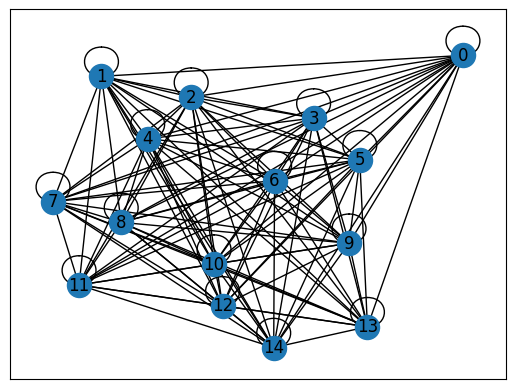

In [ ]:
# One way to apply the transformation is to directly apply it to our graphs
fc_transform = FullyConnectedTransform()
modified_graph = fc_transform(tree_dataset[0])

# Another way is to send it as argument when we first create the dataset
tree_dataset, _, _ = DictionaryLookupDataset(3).generate_data(transform=FullyConnectedTransform())
draw_one_graph(plt.axes(), tree_dataset[0].rewire_edge_index.numpy(), layout='tree')


Things looks as expected. And we definitely don't have far away nodes to be worried about.

## <font color = orange> 🖋 **Task** Modify the graph neural network model to perform the message passing propagation based on the fully connected adjacency matrix



In [ ]:
class GTpygRewireModel(Module):
    def __init__(self, output_dim, hidden_dim, num_layers=2, dim_emb=0):
        """
        Graph Transformer Neural Network using the rewired adjacency matrix
        as indicated by graph.rewire_edge_index

        The model perform root-node-level classification
        In our synthetic task the prediction needs to be done only
        from the features of the root node stored in root_mask attribute

        Args:
            output_dim: (int) - output dimension (number of classes)
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of GT layers used in the model
            dim_emb: (int) - number of potential ids/vals in the TREE
                            (characterstic to the dataset)
        """
        super(GTpygRewireModel, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2

        self.layer0_keys = Embedding(num_embeddings=dim_emb + 1, embedding_dim=hidden_dim)
        self.layer0_values = Embedding(num_embeddings=dim_emb + 1, embedding_dim=hidden_dim)

        self.layers = [GTpygLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GTpygLayer(hidden_dim, output_dim, hidden_dim)]
        self.layer_norms = [torch_geometric.nn.LayerNorm(hidden_dim) for _ in range(num_layers-1)]

        self.layers = ModuleList(self.layers)
        self.layer_norms = ModuleList(self.layer_norms)

    def forward(self, graph):
        """
        Args:
            graph (PyG.Data): batch of PyG graphs
        Returns:
            out (batch_size, output_dim): updated representation for the root nodes
        """

        # we changed the atom embedding with an id-embedding and a value-embedding
        # the final node input features will be the sum of the id and value embedding
        x_key, x_val = graph.x[:, 0], graph.x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        new_x = x_key_embed + x_val_embed
        x = new_x

        # ============ ANSWER =======================
        # This is the ORIGINAL code. Your task is to MODIFY
        # it such that instead of the original graph topology, it uses
        # the rewires version as denoted by `graph.rewire_edge_index`
        #
        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.rewire_edge_index)
          x = F.relu(x)
          x = x + new_x
          x = self.layer_norms[i](x)
          new_x = x
        x = self.layers[-1](x, graph.rewire_edge_index)
        # ===========================================

        out = x[graph.root_mask]
        return out

It's time to train our rewired model on the synthetic dataset. We will utilise the same train-test utilitaries, but using the preprocessed dataset and the new model.

In [ ]:
# @title [RUN] Hyperparameters GT

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 32 #@param {type:"integer"}
NUM_LAYERS = 2 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
tree_dataset, dim0, num_classes = DictionaryLookupDataset(4).generate_data(transform=FullyConnectedTransform())

train_syn_data = tree_dataset[:1000]
val_syn_data = tree_dataset[1000:2000]
test_syn_data = tree_dataset[2000:3000]

batch_size = 128
train_syn_loader = DataLoader(train_syn_data, batch_size=batch_size, shuffle=True)
val_syn_loader = DataLoader(val_syn_data, batch_size=batch_size, shuffle=False)
test_syn_loader = DataLoader(test_syn_data, batch_size=batch_size, shuffle=False)

In [ ]:
seed(0)
model_gt_syn_full = GTpygRewireModel(num_classes+1, HIDDEN_DIM, num_layers=NUM_LAYERS, dim_emb=dim0)
gt_perf_per_epoch = run_exp_syn(model_gt_syn_full, train_syn_loader, val_syn_loader, test_syn_loader,
                    lr=LR, n_epochs=NUM_EPOCHS)


Model architecture:
GTpygRewireModel(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (layers): ModuleList(
    (0-1): 2 x GTpygLayer()
  )
  (layer_norms): ModuleList(
    (0): LayerNorm(32, affine=True, mode=graph)
  )
)

Start training:
Epoch: 010, LR: 0.001000, Train Loss: 2.7557968,
 Val Loss: 0.3035748, Test Loss: 0.2980192
 Train Acc: 0.0950000

Epoch: 020, LR: 0.001000, Train Loss: 2.4986552,
 Val Loss: 0.3056037, Test Loss: 0.3099093
 Train Acc: 0.1690000

Epoch: 030, LR: 0.001000, Train Loss: 2.2377535,
 Val Loss: 0.3174356, Test Loss: 0.3227402
 Train Acc: 0.2490000

Epoch: 040, LR: 0.001000, Train Loss: 2.0239323,
 Val Loss: 0.3423066, Test Loss: 0.3386514
 Train Acc: 0.3260000

Epoch: 050, LR: 0.001000, Train Loss: 1.8312206,
 Val Loss: 0.3626316, Test Loss: 0.3470786
 Train Acc: 0.3890000

Epoch: 060, LR: 0.001000, Train Loss: 1.6694974,
 Val Loss: 0.3902830, Test Loss: 0.3470786
 Train Acc: 0.4500000

Epoch: 070, LR: 0.001000, Train Loss: 1.606

While running the GNN on the original graph topology couldn't learn anything, running the same model on the fully connected graph is now capable of learning the task. This validates that this rewiring approach is effective for our synthetic problem.

🤔 However, this technique brings some issues. Before moving forwards, take some times to think about potential problems.

## Expander Graphs: aiming for a sparser rewiring

Rewiring the graph into a fully connected one helps us avoiding the over-squashing issue. However, the fully-connected rewiring suffers from a strong limitation. If the graph contains a high number of nodes, connecting each pair of nodes result in a very high number of edges. This is both memory inefficient and can exhibit numerical and optimisation issues.

An ellegant solution is to [rewire the graph based on **expander graphs**](https://arxiv.org/abs/2210.02997). Expander graphs represent a class of graphs that are both sparse and highly connected. The approach remains the same: Instead of the original topology or the fully connected graph, we perform the message passing on the expander graph.

We provide the code to generate the expander graph below.


In [ ]:
# @title [RUN] Generate a set of graph expanders
# code based on: https://github.com/kpetrovicc/TGR/blob/main/modules/cayley_construction.py
"""# Cayley Graph Generation"""

import math

from collections import deque
import re
import numpy as np
import torch
from torch_geometric.utils import subgraph
import networkx as nx

_CAYLEY_BOUNDS = [
    (6, 2),
    (24, 3),
    (120, 5),
    (336, 7),
    (1320, 11),
]

def build_cayley_bank():

    ret_edges = []

    for _, p in _CAYLEY_BOUNDS:
        generators = np.array([
            [[1, 1], [0, 1]],
            [[1, p-1], [0, 1]],
            [[1, 0], [1, 1]],
            [[1, 0], [p-1, 1]]])
        ind = 1

        queue = deque([np.array([[1, 0], [0, 1]])])
        nodes = {(1, 0, 0, 1): 0}

        senders = []
        receivers = []

        while queue:
            x = queue.pop()
            x_flat = (x[0][0], x[0][1], x[1][0], x[1][1])
            assert x_flat in nodes
            ind_x = nodes[x_flat]
            for i in range(4):
                tx = np.matmul(x, generators[i])
                tx = np.mod(tx, p)
                tx_flat = (tx[0][0], tx[0][1], tx[1][0], tx[1][1])
                if tx_flat not in nodes:
                    nodes[tx_flat] = ind
                    ind += 1
                    queue.append(tx)
                ind_tx = nodes[tx_flat]

                senders.append(ind_x)
                receivers.append(ind_tx)

        ret_edges.append((p, [senders, receivers]))

    return ret_edges

def batched_augment_cayley(num_nodes, cayley_bank):

    # Find the appropriate cayley graph
    p = 2
    chosen_i = -1

    senders=[]
    receivers=[]

    for i in range(len(_CAYLEY_BOUNDS)):
        sz, p = _CAYLEY_BOUNDS[i]
        if sz >= num_nodes:
            chosen_i = i
            break
    assert chosen_i >= 0

    _p, edge_pack = cayley_bank[chosen_i]
    assert p == _p

    for v, w in zip(*edge_pack):
        if v < num_nodes and w < num_nodes:
            senders.append(v)
            receivers.append(w)

    # Create edge attributes
    edge_attr = [[0]*272 for _ in range(len(senders))]
    edge_index = [senders, receivers]
    return edge_index, edge_attr

In [ ]:
class ExpanderTransform(BaseTransform):
    def __init__(self):
        super(ExpanderTransform).__init__()
        self.cayley_bank = build_cayley_bank()

    def __call__(self, data):
        """
        Args:
            data (PyG.Data): one instance of PyG graph
        Returns:
            data (PyG.Data): original graph with an additional attribute
                             rewire_edge_index containing the edge_index for
                             an expander graph
        """
        num_nodes = data.x.shape[0]
        cayley_edge_index, cayley_edge_attr = batched_augment_cayley(num_nodes, self.cayley_bank)
        data.rewire_edge_index = torch.tensor(cayley_edge_index)
        return data

In [ ]:
expander = ExpanderTransform()

Lets have a look at how the two rewiring techniques looks like for one graph in our dataset.

In [ ]:
tree_dataset, dim0, num_classes = DictionaryLookupDataset(5).generate_data(add_self_loops=False)
# original graph
orig_data = tree_dataset[0].clone()

# expander graph
cayley_data = orig_data.clone()
cayley_data = expander(cayley_data)
cayley_data.edge_index = cayley_data.rewire_edge_index

# fully connected graph
fully_data = orig_data.clone()
fully_data = FullyConnectedTransform()(fully_data)
fully_data.edge_index = fully_data.rewire_edge_index



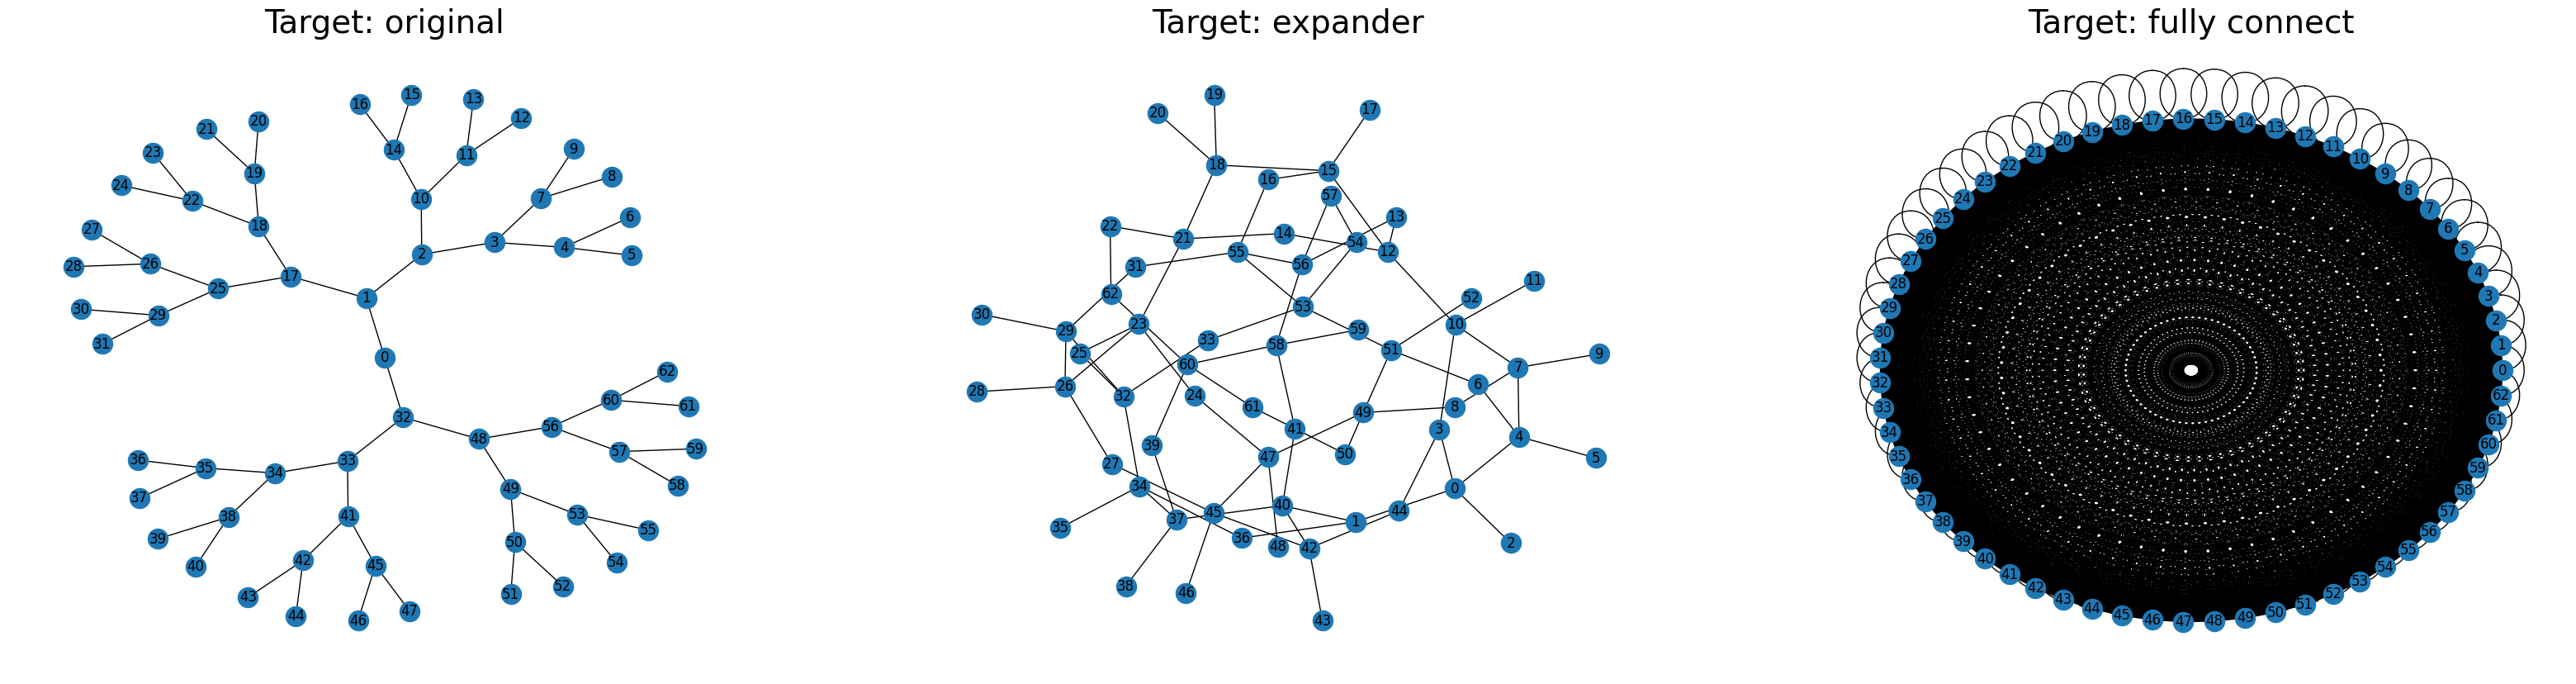

In [ ]:
# plot graphs
gallery([orig_data, cayley_data, fully_data], labels=["original", "expander", "fully connect"])


We can see that the expander graph is more connected than the original graph (thus helping in our long-distance messages problem), but far less dense compared to the fully connected approach.

In [ ]:
# @title [RUN] Hyperparameters GT

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 32 #@param {type:"integer"}
NUM_LAYERS = 5 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
tree_dataset, dim0, num_classes = DictionaryLookupDataset(4).generate_data(transform=ExpanderTransform())

train_syn_data = tree_dataset[:1000]
val_syn_data = tree_dataset[1000:2000]
test_syn_data = tree_dataset[2000:3000]

batch_size = 128
train_syn_loader = DataLoader(train_syn_data, batch_size=batch_size, shuffle=True)
val_syn_loader = DataLoader(val_syn_data, batch_size=batch_size, shuffle=False)
test_syn_loader = DataLoader(test_syn_data, batch_size=batch_size, shuffle=False)

Since the only modification are in the pre-processing stage (by rewiring based on the expander graph rather than fully connected), the graph model remains the same as above. It's time to train the model.

In [ ]:
model_gt_syn_expander = GTpygRewireModel(num_classes+1, HIDDEN_DIM, num_layers=NUM_LAYERS, dim_emb=dim0)
gt_perf_per_epoch = run_exp_syn(model_gt_syn_expander, train_syn_loader, val_syn_loader, test_syn_loader,
                    lr=LR, n_epochs=NUM_EPOCHS)


Model architecture:
GTpygRewireModel(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (layers): ModuleList(
    (0-4): 5 x GTpygLayer()
  )
  (layer_norms): ModuleList(
    (0-3): 4 x LayerNorm(32, affine=True, mode=graph)
  )
)

Start training:
Epoch: 010, LR: 0.001000, Train Loss: 2.7628113,
 Val Loss: 0.2954262, Test Loss: 0.2943383
 Train Acc: 0.0830000

Epoch: 020, LR: 0.001000, Train Loss: 2.7000085,
 Val Loss: 0.2971438, Test Loss: 0.2957750
 Train Acc: 0.1150000

Epoch: 030, LR: 0.001000, Train Loss: 2.6305189,
 Val Loss: 0.3021222, Test Loss: 0.2957750
 Train Acc: 0.1420000

Epoch: 040, LR: 0.001000, Train Loss: 2.5405335,
 Val Loss: 0.3120529, Test Loss: 0.2957750
 Train Acc: 0.1660000

Epoch: 050, LR: 0.001000, Train Loss: 2.4725229,
 Val Loss: 0.3298852, Test Loss: 0.2957750
 Train Acc: 0.1810000

Epoch: 060, LR: 0.001000, Train Loss: 2.3856859,
 Val Loss: 0.3373900, Test Loss: 0.3329029
 Train Acc: 0.2040000

Epoch: 070, LR: 0.001000, Train Loss:

❗Note that, while for the fully connected approach a single layer is enough to send the messages between any pair of nodes, the expander one might need more than a single layer since, while being more connected than our original graph, it still exhibits some sparsity.

For our synthetic task, the model might converge slower than the previous version, however it is still capable of learning the task. Moreover, the operations inside the model are much more efficient due to the sparser topology.

🍸 It was an intense journey so far!! We learned how to implement and train a GNN both from scratch and using the PyG library, and we even got in contact with some of the hot open-problems in the GNN research field.

⏩ The main purpose of this tutorial is to make you familiar with graph deep learning and what you can do with it. However, besides the over-squashing solutions presented here, there is much more out there that we didn't have time to cover. These includes techniques such as virtual nodes or dynamic rewiring. If you are interested to find out more about all of these, we included a list of papers [in the end of this tutorial](#references).

# <font color=green> 🧘 [Bonus] **Positional Encoding for Graph Data** </font>

The major issue with the rewiring approaches presented so far is that we **completly ignore the original graph topology**. While for our synthetic problem the graph doesn't influence the output, this is unlikely to be the case in real-world problems, such as the solubility prediction in ZINC dataset. Ideally, we would like to be able to overcome over-squashing, while still being aware of the graph structure we are working on.

One solution to recover the graph topology is by incorporating extra features, known as **positional encodings**. These are additional input features summarizing various graph statistics. Some popular choices include [laplacian eigenvectors](https://arxiv.org/abs/2003.00982), features extracted using [random walks](https://arxiv.org/pdf/2110.07875) or [learnable positional encoding](https://arxiv.org/pdf/2307.07107).

In the following, we implemented a data transformation to pre-compute the laplacian eigenvector necessariy to encode graph structure information.

For each node, the positional encoding corresponding to that node will be represented by the eigenvector associated with the smallest `emb_dim` eigenvalues and will be store in `data.pos`.


In [ ]:
# this is the dimension of the positional encoding
POSEMB_DIM = 16 #@param {type:"integer"}

In [ ]:
class AddLaplacianPETransform(BaseTransform):
    def __init__(self, emb_dim):
        """
        Args:
            emb_dim (int): dimension of the positional encoding
        """
        super(AddLaplacianPETransform).__init__()
        self.emb_dim = emb_dim

    def __call__(self, data):
        """
        Args:
            data (PyG.Data): one instance of PyG graph
        Returns:
            data (PyG.Data): original graph with an additional attribute
                             pos (n, emb_dim) containing the top emb_dim eigenvectors
        """
        num_nodes  = data.x.shape[0]

        edge_index, edge_weight = get_laplacian(
                      data.edge_index,
                      normalization='sym',
                      num_nodes=num_nodes,
                      )

        L = to_scipy_sparse_matrix(edge_index, edge_weight, num_nodes)
        eig_vals, eig_vecs = eig(L.todense())


        eig_vecs = np.real(eig_vecs[:, eig_vals.argsort()])

        pe = torch.from_numpy(eig_vecs[:, 1:self.emb_dim + 1])
        if pe.shape[1] < self.emb_dim:
            pe = torch.cat((pe, torch.zeros(pe.shape[0], self.emb_dim-pe.shape[1])), axis=-1)
        sign = -1 + 2 * torch.randint(0, 2, (self.emb_dim, ))
        pe *= sign

        data.pos = pe
        return data

In [ ]:
tree_dataset, _, _ = DictionaryLookupDataset(3).generate_data(transform=AddLaplacianPETransform(POSEMB_DIM))
print(f"The positional encoding for node 5 is: {tree_dataset[0].pos[5]}")

The positional encoding for node 5 is: tensor([-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.5701e-16,
         0.0000e+00, -0.0000e+00, -1.1102e-16,  0.0000e+00, -0.0000e+00,
        -0.0000e+00])


## <font color = orange> 🖋 **Task** Modify the graph neural network model to incorporate the positional encoding, while still using fully connected adjacency matrix </font>

> We expect two distinct modification for this task:
  1.  same as before, use the rewired connected adjacency matrix as opposed to the original graph topology
  2. before any processing, concatenate the additional positional encoding computed above to the initial features.

In [ ]:
class GTpygPEModel(Module):
    def __init__(self, hidden_dim, num_layers=2):
        """Graph Transformer Neural Network model using node-level PE

        Args:
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of layers
        """
        super(GTpygPEModel, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2

        self.embed_x = Embedding(28, hidden_dim)

        # ============ ANSWER =======================
        # This is the ORIGINAL code used before. Your task is to MODIFY
        # it such that it takes into account the newly added features.
        # Hint: What is happening with the input dimension in the first layer?
        #
        self.layers = [GTpygLayer(hidden_dim+POSEMB_DIM, hidden_dim, hidden_dim)]
        # ===========================================

        self.layers += [GTpygLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-2)]
        self.layers += [GTpygLayer(hidden_dim, 1, hidden_dim)]

        self.layers = ModuleList(self.layers)

    def forward(self, graph):
        """
        Args:
            graph: (PyG.Data) - batch of PyG graphs
        Returns:
           out: (batch_size,) - scalar prediction for each graph in the batch
        """
        new_x = self.embed_x(graph.x).squeeze(1)

        # ============ ANSWER =======================
        # Concatenate the positional encoding computed in thge transformation
        # wit the input features new_x
        #
        x = torch.cat((new_x, graph.pos), axis=-1)
        # ===========================================


        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.rewire_edge_index)
          x = F.relu(x)

        x = self.layers[-1](x, graph.rewire_edge_index)

        out = global_add_pool(x, graph.batch)
        out = out.squeeze(-1)
        return out

In [ ]:
# @title [RUN] Hyperparameters GT

NUM_EPOCHS =  50 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 2 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
batch_size = 64

train_ds = ZINC(root='data/ZINC', split='train', subset=True,  transform=T.Compose([FullyConnectedTransform(), AddLaplacianPETransform(POSEMB_DIM)]))
val_ds = ZINC(root='data/ZINC', split='val', subset=True, transform=T.Compose([FullyConnectedTransform(), AddLaplacianPETransform(POSEMB_DIM)]))
test_ds = ZINC(root='data/ZINC', split='test', subset=True, transform=T.Compose([FullyConnectedTransform(), AddLaplacianPETransform(POSEMB_DIM)]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
model_gt_pe = GTpygPEModel(HIDDEN_DIM, num_layers=NUM_LAYERS)
stats = run_exp_pyg(model_gt_pe,  train_loader, val_loader, test_loader, loss_fct=F.mse_loss,
                    lr=LR, num_epochs=NUM_EPOCHS)


Model architecture:
GTpygPEModel(
  (embed_x): Embedding(28, 64)
  (layers): ModuleList(
    (0-1): 2 x GTpygLayer()
  )
)

Start training:
[Epoch 1] train loss: 0.858 val loss: 1.767
[Epoch 2] train loss: 0.437 val loss: 1.582
[Epoch 3] train loss: 1.513 val loss: 2.005
[Epoch 4] train loss: 0.931 val loss: 1.520
[Epoch 5] train loss: 1.566 val loss: 1.515
[Epoch 6] train loss: 0.483 val loss: 1.587
[Epoch 7] train loss: 1.037 val loss: 1.530
[Epoch 8] train loss: 8.410 val loss: 1.512
[Epoch 9] train loss: 1.324 val loss: 1.636
[Epoch 10] train loss: 1.467 val loss: 1.710
[Epoch 11] train loss: 1.527 val loss: 1.544
[Epoch 12] train loss: 0.491 val loss: 1.509
[Epoch 13] train loss: 27.549 val loss: 1.669
[Epoch 14] train loss: 0.744 val loss: 1.608
[Epoch 15] train loss: 1.597 val loss: 1.563
[Epoch 16] train loss: 1.596 val loss: 1.586
[Epoch 17] train loss: 0.460 val loss: 1.565
[Epoch 18] train loss: 2.854 val loss: 1.560
[Epoch 19] train loss: 0.914 val loss: 1.532
[Epoch 20] t

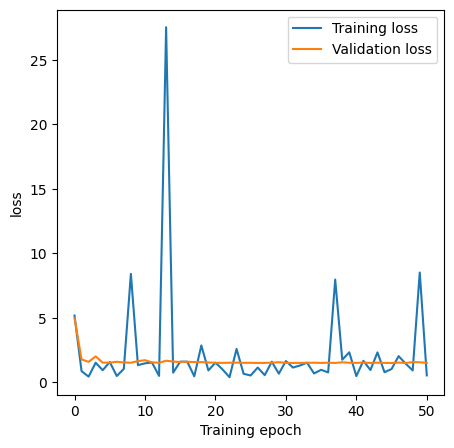

In [ ]:
plot_stats(stats)

If you are familiar with the NLP research, this entire model might look very familiar: we have a set of nodes, that we enriched with positional encoding, and than we exchange information between each pair of two nodes based on a key-value attention mechanism. It is basically a **Transformer architecture** applyed on a sequence of nodes instead of a sequence of word tokens.

## Asolute vs Relative Positional Encoding

Inspired from the NLP community, [two types of positional encoding recently emerges](https://arxiv.org/abs/2402.14202): **<ins>absolute</ins> positional encoding** and **<ins>relative</ins> positional encoding**. The *absolute positional encoding* summarizes the graph structure as node features (as we did above with the laplacian eigenvectors). On the other hand, the *relative positional encoding* represents the graph structure as an embedding of pairs of nodes (i.e. edges). Examples of relative positional encoding include boolean identifiers ($0$ for additional edges and a $1$ for the original topology), [resistance distance](https://arxiv.org/abs/2301.09505) or [shortest-path](https://arxiv.org/pdf/2106.05234).

## <font color = orange> 🖋 **Task** Implement a transformation to compute the relative positional encoding based on the shortest-path distance.

> For each pair of two nodes, the extra feature will be an integer denoting the shortest path between the two nodes. Note that this can only make sense in conjuction with a rewiring transformation, otherwise all the shortest-path distances would be 1.



In [ ]:
class AddRelativePETransform(BaseTransform):
    def __init__(self):
        super(AddRelativePETransform).__init__()
    def __call__(self, data):
        """
        Args:
            data (PyG.Data): one instance of PyG graph
        Returns:
            data (PyG.Data): original graph with an additional attribute
                             edge_attr (e,) containing the shortest-path between
                             each pair of two nodes connected in the rewired graph
        """
        orig_data = Data(x=data.x, edge_index=data.edge_index)
        G = torch_geometric.utils.to_networkx(orig_data).to_undirected()

        # ============ ANSWER =======================
        # For each pair of 2 nodes in  data.rewire_edge_index (2, e),
        # compute their shortest path and store it in `edge_attr`: (e,)
        # Hint: nx.shortest_path_length can be used to compute the shortest paths
        #
        edge_attr = []
        num_edges = data.rewire_edge_index.shape[1]
        for i in range(num_edges):
            x_i = data.rewire_edge_index[0][i].item()
            x_j = data.rewire_edge_index[1][i].item()
            try:
                length = nx.shortest_path_length(G, x_i, x_j)
            except nx.NetworkXNoPath:
                length = 22 # this means no path exists
            edge_attr.append(length)
        # ===========================================

        data.edge_attr = torch.tensor(edge_attr)
        return data

The relative positional encoding for the edge between 0 and 5 is : 2


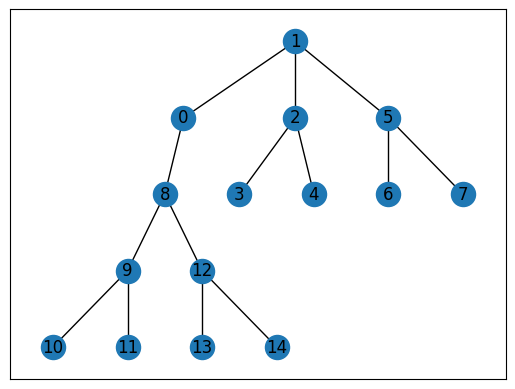

In [ ]:
tree_dataset, _, _ = DictionaryLookupDataset(3).generate_data(add_self_loops=False, transform=T.Compose([FullyConnectedTransform(), AddRelativePETransform()]))
draw_one_graph(plt.axes(), tree_dataset[0].edge_index.numpy(), layout='tree')
print(f"The relative positional encoding for the edge between {tree_dataset[0].rewire_edge_index[0][5]} and {tree_dataset[0].rewire_edge_index[1][5]} is : {tree_dataset[0].edge_attr[5]}")

## <font color = orange> 🖋 **Task** Modify the GNN Layer below to incorporate the relative positional encoding when computing the attention cofficient.

> While there are several ways in which we can do that, for this practical we will implement the following function:
>
> \begin{align}
f_{msg}(x_i, x_j)=\sigma(k(x_i)^Tq(x_j) \color{red}+\color{red}r_\color{red}{ij})v(x_j)
\end{align}
>
> where $\sigma$ is the softmax non-linearity and $r_{ij}$ is the relative positional encoding (the shortest-path between $i$ and $j$ in our case).

In [ ]:
class GTpygRPeLayer(MessagePassing):
    def __init__(self, in_dim, out_dim, hid_dim):
        """Sparse Graph Transformer Layer implemented using Pytorch Geometric

        Args:
            in_dim: (int) - input dimension for node features
            out_dim: (int) - output dimension
            hid_dim: (int) - hidden dimension
            aggr: (int) - the type of aggregation used in the message passing
        """
        super().__init__(node_dim=0, aggr='add')
        self.in_dim = in_dim
        self.out_dim = out_dim

        # ============ ANSWER =======================
        # Add new layers to compute the three linear projections
        # these should be the same code as before
        # x_i -> q(x_i); x_j -> k(x_i); x_j -> v(x_i)
        #
        self.lin_q = Linear(in_dim, hid_dim, bias=False)
        self.lin_k = Linear(in_dim, hid_dim, bias=False)
        self.lin_v = Linear(in_dim, out_dim, bias=False)
        # ===========================================
        # convert the scalar denoting shortest-path into an embedding
        # maximum shortest path is set to 23.
        self.lin_attr = Embedding(23, 1)

    def forward(self, x, edge_index, edge_attr):
        """
        Args:
            x: (n, in_dim) - initial node features
            edge_index: (2, e) - list of edges as a tuple
            edge_attr: (e, ) - relative positional encoding

        Returns:
            out: (n, out_dim) - updated node features
        """
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out


    def message(self, x_i, x_j, edge_index_j, edge_attr):
        """
        Args:
            x_i: (e, in_dim) - features corresponding to destination nodes
            x_j: (e, in_dim) - features corresponding to source nodes
            index: (e, d_e) - node index used to guide the softmax computation
            size_i - number of destination nodes
            edge_attr: (e,)

        Returns:
            out: (n, out_dim) - updated node features
        """
        # ============ ANSWER =======================
        # Compute the message function from the equation above
        # Hint: some of the code should be similar to the one that
        # your wrote for the GTpygLayer.
        #
        query_i = self.lin_q(x_i)
        key_j = self.lin_k(x_j)
        value_j = self.lin_v(x_j)
        edge_attr = self.lin_attr(edge_attr)

        alpha = (query_i * key_j).sum(dim=-1) + edge_attr.squeeze()
        alpha = softmax(alpha, edge_index_j)
        out = value_j * alpha.view(-1, 1)
        # ===========================================
        return out

The model class is the same as before, but using the extra argument for edge_attribute.

In [ ]:
class GTpygRPeModel(Module):
    def __init__(self, hidden_dim, num_layers=2):
        """
        Graph Transformer Neural Network model using rewiring and
        relative positional encoding

        Args:
            hidden_dim: (int) - hidden dimension
            num_layers: (int) - number of GT layers used in the model
        """
        super(GTpygRPeModel, self).__init__()
        self.num_layers = num_layers

        self.embed_x = Embedding(28, hidden_dim)

        self.layers = [GTpygRPeLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GTpygRPeLayer(hidden_dim, 1, hidden_dim)]

        self.layers = ModuleList(self.layers)

    def forward(self, graph):
        """
        Args:
            graph: (PyG.Data) - batch of PyG graphs
        Returns:
            out: (batch_size,) - scalar prediction for each graph in the batch
        """

        new_x = self.embed_x(graph.x).squeeze(1)
        x = new_x
        for i in range(self.num_layers-1):
          x = self.layers[i](x, graph.rewire_edge_index, graph.edge_attr)
          x = F.relu(x)

        x = self.layers[-1](x, graph.rewire_edge_index, graph.edge_attr)

        out = global_add_pool(x, graph.batch)
        out = out.squeeze(-1)
        return out

Lets train the model once again, this time using the relative positional encoding.

❗️Note that the training of the `GTpygRPeModel` is quite slow 🐢. For the purpose of this tutorial, it is enough to test that it runs for a couple of iterations. If you want to see results and colab's credit is not enough we suggest moving the training to a local machine.

In [ ]:
# @title [RUN] Hyperparameters GT with relative PE

NUM_EPOCHS =  50 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}
HIDDEN_DIM = 64 #@param {type:"integer"}
NUM_LAYERS = 2 #@param {type:"integer"}


#you can add more here if you need

In [ ]:
batch_size = 64

train_ds = ZINC(root='data/ZINC', split='train', subset=True, transform=T.Compose([FullyConnectedTransform(), AddRelativePETransform()]))
val_ds = ZINC(root='data/ZINC', split='val', subset=True, transform=T.Compose([FullyConnectedTransform(), AddRelativePETransform()]))
test_ds = ZINC(root='data/ZINC', split='test', subset=True, transform=T.Compose([FullyConnectedTransform(), AddRelativePETransform()]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
model_gt_rpe = GTpygRPeModel(HIDDEN_DIM, num_layers=NUM_LAYERS)
stats = run_exp_pyg(model_gt_rpe, train_loader, val_loader, test_loader, loss_fct=F.mse_loss,
                    lr=LR, num_epochs=NUM_EPOCHS)

In [ ]:
plot_stats(stats)

💡 Positional encoding is not the only way to preserve the original topology when using rewiring techniques. One possible solutions is to alternate between layers of message passing on the original graph and layers of message passing on the rewired graph. Feel free to experiment more with this.

🏆 Well done!! You arrived at the end of this tutorial. We hope that you are now familiar with working with graph data and you were developing a good intuition about the cause and solutions for some of the hard problems in graph community. If you have any queries or feedback don't hesitate to contact us!

<a name="references"></a>
# 🍫 Want to learn more?

If you are interested in finding more about these topics, here is a selection of papers that you might find useful:

⚫ [On the Bottleneck of Graph Neural Networks and its Practical Implications](https://arxiv.org/abs/2006.05205) \\
🟢 [Expander graph propagation](https://arxiv.org/abs/2210.02997) \\
🟣 [Drew: Dynamically rewired message passing with delay](https://arxiv.org/abs/2305.08018) \\
🔵 [On Over-Squashing in Message Passing Neural Networks: The Impact of Width, Depth, and Topology](https://arxiv.org/abs/2302.02941) \\
🟡 [Understanding over-squashing and bottlenecks on graphs via curvature](https://arxiv.org/abs/2111.14522) \\
🟠 [Probabilistically Rewired Message-Passing Neural Networks](https://arxiv.org/abs/2310.02156) \\
🔴 [Graph Neural Networks with Learnable Structural and Positional Representations](https://arxiv.org/abs/2110.07875) \\
🟤 [A Generalization of Transformer Networks to Graph](https://arxiv.org/abs/2012.09699)